In [1]:
import numpy as np
import pandas as pd

import os
from collections import Counter

import matplotlib.pyplot as plt
import seaborn as sns
import statannot

from sklearn.utils import resample
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer

from lifelines import CoxPHFitter
from lifelines import KaplanMeierFitter

from lifelines.utils import concordance_index
from xgboost import XGBRegressor,XGBClassifier
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet

from keras.models import Sequential
from keras.layers import Dense, Dropout

from scipy.stats import mannwhitneyu,wilcoxon,shapiro, levene, ttest_ind,f_oneway,kruskal


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, normalize, StandardScaler
from sklearn.metrics import roc_curve, auc, accuracy_score, make_scorer,precision_recall_curve
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.linear_model import Lasso, LogisticRegression
from sklearn.svm import SVC
from abc import ABC, abstractmethod

import shap

import warnings
warnings.filterwarnings("ignore")


2024-10-11 16:30:34.782068: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-10-11 16:30:34.786211: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-10-11 16:30:34.839367: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-10-11 16:30:35.610204: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


# Functions and Classes

## Models

In [2]:

def init_models():
    # Lasso (Logistic Regression with L1 penalty)
    lasso_model = LogisticRegression(penalty='l1',C=1, solver='liblinear')

    # XGB
    xgb_model = XGBClassifier(
        use_label_encoder=False,
        eval_metric='logloss'
    )
    # xgb_model.fit(X_train, y_train, eval_set=[(X_test, y_test)], early_stopping_rounds=50, verbose=False)


    # SVM Model
    svm_model = SVC(kernel='linear', probability=True)
    elastic_net_model = ElasticNet()  # Add ElasticNet model initialization
    elastic_net_model = LogisticRegression(penalty='elasticnet', solver='saga', l1_ratio=0.5)
    # cox_boost_model = CoxPHFitter()   # Add CoxBoost model initialization
    return lasso_model, xgb_model, svm_model, elastic_net_model

In [3]:
class ModelStatStorage:
    def __init__(self, aucs=[], fprs=[], tprs=[], model=[]):
        self.aucs = aucs
        self.fprs = fprs
        self.tprs = tprs
        self.model = model
        self.X_train = []
        self.X_test = []
        self.y_train = []
        self.y_test = []
        self.y_pred = []
        self.pred_probas = []
        self.scores = []


class Model(ABC):
    # test_H_mask = X_test['id'] < 60
    # test_L_mask = X_test['id'] >= 60
    def __init__(self, model_name, param_dict):
        """
        Arguments:
        model_name - name of model
        param_dict - params to be passed to model
        """

        # 用于存储模型相关参数
        # store results of each fold of cross val
        self.cv_storage = ModelStatStorage([], [], [], [])

        # access actual self.model underneath for increased control if needed
        self.model_name = model_name
        self.model = self.init_model(model_name, param_dict)
        # self.cv_storage = CVModelStorage([], [], [], []) #store results of each fold of cross val
        # stores the index of the model with best score, within cv_storage lists
        self.argmax_ind = -1
        self.params_dict = param_dict
        self.train_splits = []
        self.SEED = 13

    @abstractmethod
    def init_model(self, model_name, param_dict):
        """ 
            Returns model initialized with param_dict parameters
        """
        pass

    def train_model(self, X_train, y_train):
        self.model.fit(X_train, y_train)

    def get_scores(self, X_train, y_train, X_test, y_test):
        clf = self.model
        train_score = clf.score(X_train, y_train)
        test_score = clf.score(X_test, y_test)
        return train_score, test_score

    def get_H_L_score(self, X_test, y_test):
        pass

    def show_performance(self):
        results = []
        model_performance = self.cv_storage
        for record in zip([self.model_name]*len(model_performance.aucs), model_performance.aucs, model_performance.scores):
            results.append(record)
        results_df = pd.DataFrame(
            results, columns=['model', 'aucs', 'accuracy'])
        print(results_df)
        results_df = results_df.groupby(by=['model']).mean()
        print(results_df)

    def get_performance_df(self):
        results = []
        model_performance = self.cv_storage
        for record in zip([self.model_name]*len(model_performance.scores), model_performance.aucs, model_performance.scores):
            results.append(record)
        results_df = pd.DataFrame(
            results, columns=['model', 'auc', 'accuracy'])
        return results_df

    def run_k_fold(self, X, y, n_splits=5,is_multiclass=False):
        '''
         Input X is a 2d list, y is a list.
        '''
        skf = StratifiedKFold(
            n_splits=n_splits, shuffle=True, random_state=self.SEED)
        for train, test in skf.split(X, y):
            X_train = X.iloc[train, :]
            y_train = y.iloc[train,:]
            X_test = X.iloc[test, :]
            y_test = y.iloc[test,:]
            self.train_model(X_train, y_train)

            if hasattr(self.model, 'predict_proba'):
                pred_proba = self.model.predict_proba(X_test)
            else:
                print("Multiclass currently do not supports predict_proba")
                pred_proba = None
            if is_multiclass:
                # make a one hot multiclass label
                y_one_hot = np.zeros(pred_proba.shape)
                for idx, label in enumerate(y_test):
                    y_one_hot[idx, label] = 1
                fpr, tpr, _ = roc_curve(y_one_hot.ravel(), pred_proba.ravel())
            else:
                fpr, tpr, _ = roc_curve(y_test, pred_proba[::,1])
            a = auc(fpr, tpr)
            self.cv_storage.pred_probas.append(pred_proba)
            self.cv_storage.aucs.append(a)
            self.cv_storage.fprs.append(fpr)
            self.cv_storage.tprs.append(tpr)
            # self.cv_storage.model.append(pickle.dumps(self.model))
            self.cv_storage.X_train.append(X_train)
            self.cv_storage.y_train.append(y_train)
            self.cv_storage.X_test.append(X_test)
            self.cv_storage.y_test.append(y_test)
            self.cv_storage.scores.append(self.model.score(X_test, y_test))


# XGB
class XGB(Model):
    def init_model(self, model_name, param_dict):
        param_dict = dict({'eval_metric': 'mlogloss'}, **param_dict)
        clf = XGBClassifier(**param_dict)
        return clf

# Lasso
class Lasso_Model(Model):
    def init_model(self, model_name, param_dict):
        param_dict = dict(
            {'penalty': 'l1', 'solver': 'liblinear'}, **param_dict)
        clf = LogisticRegression(**param_dict)
        # clf=Lasso(**param_dict)
        return clf

    def train_model(self, X_train, y_train):
        super().train_model(X_train, y_train)

# SVM
class SVM_Model(Model):
    def init_model(self, model_name, param_dict):
        param_dict = dict({'decision_function_shape': 'ovo',
                          'probability': True}, **param_dict)
        clf = SVC(**param_dict)
        return clf

    def train_model(self, X_train, y_train):
        # 欠拟合时不要加入正则项
        # X_train=normalize(X_train,norm='l1')
        scaler = StandardScaler().fit(X_train)
        X_train = scaler.transform(X_train)
        super().train_model(X_train, y_train)


## Functions

### Data Preparation

In [4]:
def get_survival_level(sample,low=12,high=48):
    if sample.oss==0:
        if sample.os<low:
            return None
        else:
            if sample.os>=high:
                return 'high'
            else:
                return None
    if sample.oss==1:
        if sample.os>=high:
            return 'high'
        if sample.os<low:
            return 'low'
        if (sample.os>=low)&(sample.os<high):
            return None

### Sig Features to File

In [5]:
def write_list_to_file(lst, filename):
    with open(filename, 'w') as f:
        for item in lst:
            f.write("%s\n" % item)
def read_list_from_file(filename):
    with open(filename, 'r') as f:
        lines = f.readlines()
        # Remove newline characters
        lines = [line.strip() for line in lines]
    return lines


### Shap Selection

In [6]:
def get_important_feature_indexes(mean_shap, feature_num=10, select_method=2):
    '''
    0-负相关，1-正相关，2-绝对值
    '''
    if select_method == 2:
        mean_shap = np.absolute(mean_shap)
    mean_shap_sort = mean_shap.argsort()
    # 选择倒数n个
    if select_method == 2:
        feature_num = -feature_num
        feature_indexes = mean_shap_sort[feature_num:]
    if select_method == 1:
        feature_num = -feature_num
        feature_indexes = mean_shap_sort[feature_num:]

    if select_method == 0:
        feature_indexes = mean_shap_sort[:feature_num]

    feature_indexes = list(feature_indexes)
    return feature_indexes

In [7]:

def get_fold_mean_shap_value(clf_model):
    fold_num = len(clf_model.cv_storage.X_train)
    fold_mean_shap_value = []
    for i in range(fold_num):
        # clf = pickle.loads(clf_model.cv_storage.model[i])
        X_train = clf_model.cv_storage.X_train[i]
        X_test = clf_model.cv_storage.X_test[i]
        # define explainer
        explainer = shap.Explainer(clf_model.model)
        shap_values = explainer.shap_values(X_test)
        # special process for multi-class
        shap_values=np.array(shap_values)
        if(len(shap_values.shape)>2):
            shap_values=np.mean(shap_values, axis=0)
        shap_values = np.mean(shap_values, axis=0)
        fold_mean_shap_value.append(shap_values)
    # process on mean shap
    fold_mean_shap_value = np.mean(np.array(fold_mean_shap_value), axis=0)
    return fold_mean_shap_value


In [8]:

def get_important_feature_by_shap(X,y, feature_num=10):
    '''
        input X,y, feature_num
    '''
    # pre train
    clf_model=XGB('XGB',{})
    clf_model.run_k_fold(X,y)
    # get mean shap value by different folds
    fold_mean_shap_value = get_fold_mean_shap_value(clf_model)
    # get indexes of features
    feature_indexes = get_important_feature_indexes(
        fold_mean_shap_value, feature_num=feature_num)
    # get names of features
    cols = X.columns
    features = cols[feature_indexes]
    features=features[::-1]

    return list(features)

### Statistics Selection

In [9]:

def get_pvalue_dict(df,label_col,unwanted_cols=[]):
    
    # delete unwanted
    colnames = df.columns
    colnames = list(set(colnames)-set([label_col])-set(unwanted_cols))
    classes=list(dict(sorted(dict(df.value_counts(label_col)).items())).keys())
    print(classes)
    pvalue_dict={}
    if(len(classes)>2):
        for i,colname in enumerate(colnames):
            class_features=[]
            df=df.astype({colname:float})
            for label in classes:
                tmp_feature=[]
                # tmp_feature = df.loc[(df[label_col] == label)]
                tmp_feature = df.loc[(df[label_col] == label)].loc[:, colname].tolist()
                class_features.append(tmp_feature)

            _, p_value = kruskal(*class_features)
            pvalue_dict[colname]=p_value
    else:
        for i,colname in enumerate(colnames):
            class_features=[]
            df=df.astype({colname:float})
            for label in classes:
                tmp_feature=[]
                # tmp_feature = df.loc[(df[label_col] == label)]
                tmp_feature = df.loc[(df[label_col] == label)].loc[:, colname].tolist()
                class_features.append(tmp_feature)

            _, p_value = mannwhitneyu(*class_features)
            pvalue_dict[colname]=p_value
        
    return pvalue_dict
def get_important_feature_by_stat(df,label_col,unwanted_cols=[]):
    colnames = df.columns
    colnames = list(set(colnames)-set([label_col])-set(unwanted_cols))
    classes=list(dict(sorted(dict(df.value_counts(label_col)).items())).keys())
    important_features=[]
    for i,colname in enumerate(colnames):
            class_features=[]
            df=df.astype({colname:float})
            for label in classes:
                tmp_feature=[]
                # tmp_feature = df.loc[(df[label_cols[0]] == label)]
                tmp_feature = df.loc[(df[label_col] == label)].loc[:, colname].tolist()
                class_features.append(tmp_feature)

            _, p_value = mannwhitneyu(*class_features)
            if p_value<5e-2:
                important_features.append(colname)
    return important_features

### Visulization

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt

def filter_outliers_df(df):
    def filter_outliers_iqr(series):
        Q1 = series.quantile(0.25)
        Q3 = series.quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        return series[(series >= lower_bound) & (series <= upper_bound)]
    
    return df.apply(filter_outliers_iqr, axis=0)

def draw_box(df, target_features, class_label, filepath=''):
    """
    Function to draw boxplots and scatter plots for specified features.
    
    Parameters:
    df (pd.DataFrame): DataFrame containing the data.
    target_features (list): List of feature names to plot.
    class_label (str): Name of the class label column.
    filepath (str, optional): Path to save the plot. If empty, the plot is displayed.
    """
    target_cols = []
    pvalue_dict = get_pvalue_dict(df.loc[:, target_features + [class_label]], class_label)
    print(pvalue_dict)
    num_features = len(target_features)
    cols = 5
    rows = int(np.ceil(num_features / cols))

    fig, axes = plt.subplots(rows, cols, figsize=(cols * 4, rows * 5))
    axes = axes.flatten()
    fig.suptitle('Shap', fontsize=16)
    order = None
    df.loc[:,target_features]=filter_outliers_df(df.loc[:,target_features])
    for index, feature in enumerate(target_features):
        ax = axes[index]
        feature_name = feature
        ax.set_title(feature_name, fontsize=16)
        
        using_colors = sns.color_palette("tab10", 2)
        
        # Draw boxplot
        sns.boxplot(data=df, x=class_label, y=feature_name, 
                    order=order, ax=ax,
                    showmeans=False, 
                    meanline=False, 
                    meanprops={"linewidth": 2},showfliers=False,palette=using_colors,
                    linewidth=3,width=0.5
                    )
        # Draw scatter plot
        sns.stripplot(data=df, x=class_label, y=feature_name, 
                      s=5, order=order, color='gray',# hue=class_label,
                    #   palette=using_colors, 
                      alpha=0.7, ax=ax, dodge=False)
        
        p_value = pvalue_dict[feature_name]
        if p_value < 0.0001:
            ax.legend(["p<0.0001"], loc='upper left', borderaxespad=1, handlelength=0, handletextpad=0)
        else:
            ax.legend(["p=%.4f" % p_value], loc='upper left', borderaxespad=1, handlelength=0, handletextpad=0)
        
        # ax.set_yticklabels([])
        ax.set_ylabel("")
        ax.set_xlabel("")
        # ax.get_legend().remove()

    # Remove unused subplots
    for i in range(num_features, len(axes)):
        fig.delaxes(axes[i])

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.suptitle(selection_method,fontsize=20)
    # Save or show the figure
    if filepath == '':
        plt.show()
    else:
        filepath = filepath + 'Shap.png'
        filepath = filepath.replace(':', '-')
        plt.savefig(filepath)


In [11]:

# Function to plot ROC curves
def plot_cv_roc_curve(classifier, X, y, label, ax):
    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)
    
    for i, (train, test) in enumerate(cv.split(X, y)):
        # print(f"train:{train},test:{test}")
        probas_ = classifier.fit(X.iloc[train], y.iloc[train,0].values).predict_proba(X.iloc[test])
        fpr, tpr, _ = roc_curve(y.iloc[test], probas_[:, 1])
        tprs.append(np.interp(mean_fpr, fpr, tpr))
        roc_auc = auc(fpr, tpr)
        aucs.append(roc_auc)
        ax.plot(fpr, tpr, lw=1, alpha=0.3, label=f'ROC fold {i} (AUC = {roc_auc:.2f})')

    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = np.mean(aucs)
    std_auc = np.std(aucs)
    ax.plot(mean_fpr, mean_tpr, color='b',
            label=f'Mean ROC (AUC = {mean_auc:.4f} ± {std_auc:.4f})',
            lw=2, alpha=.8)

    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                    label='± 1 std. dev.')

    ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', alpha=.8)
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title(f'ROC Curve with Cross-Validation for {label}')
    ax.legend(loc='lower right')


#### PRC

In [12]:

# Function to plot ROC curves
def plot_cv_prc_curve(classifier, X, y, label, ax):
    recalls = []
    aucs = []
    mean_precision = np.linspace(0, 1, 100)
    
    for i, (train, test) in enumerate(cv.split(X, y)):
        print(f"train:{train},test:{test}")
        probas_ = classifier.fit(X.iloc[train], y.iloc[train,0].values).predict_proba(X.iloc[test])
        precision, recall, _ = precision_recall_curve(y.iloc[test], probas_[:, 1])
        recalls.append(np.interp(mean_precision, precision, recall))
        sorted_indices = np.argsort(recall)
        sorted_recall = np.array(recall)[sorted_indices]
        sorted_precision = np.array(precision)[sorted_indices]

        # Calculate AUPRC using the trapezoidal rule
        auprc = np.trapz(precision, recall)
        aucs.append(auprc)
        ax.plot(sorted_recall, sorted_precision, lw=1, alpha=0.3, label=f'ROC fold {i} (AUC = {auprc:.2f})')

    # mean_recall = np.mean(recalls, axis=0)
    # mean_recall[-1] = 1.0
    # mean_auc = np.mean(aucs)
    # std_auc = np.std(aucs)
    # ax.plot(mean_precision, mean_recall, color='b',
    #         label=f'Mean ROC (AUC = {mean_auc:.4f} ± {std_auc:.4f})',
    #         lw=2, alpha=.8)

    # std_recall = np.std(recalls, axis=0)
    # recalls_upper = np.minimum(mean_recall + std_recall, 1)
    # recalls_lower = np.maximum(mean_recall - std_recall, 0)
    # ax.fill_between(mean_precision, recalls_lower, recalls_upper, color='grey', alpha=.2,
    #                 label='± 1 std. dev.')

    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title(f'ROC Curve with Cross-Validation for {label}')
    ax.legend(loc='lower right')


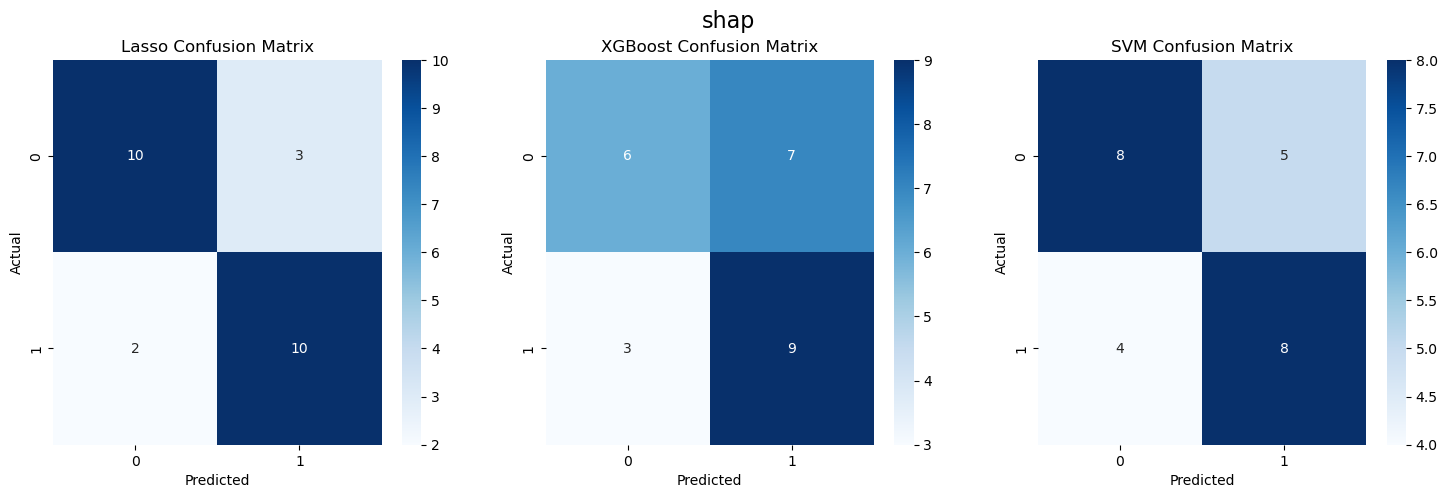

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# # Bar plot of accuracy
# models = ['Lasso', 'XGBoost', 'SVM']
# accuracies = [
#     accuracy_score(y_test, lasso_predictions),
#     accuracy_score(y_test, xgb_predictions),
#     accuracy_score(y_test, svm_predictions)
# ]

# plt.figure(figsize=(10, 6))
# sns.barplot(x=models, y=accuracies)
# plt.xlabel('Models')
# plt.ylabel('Accuracy')
# plt.title('Comparison of Model Performance')
# plt.show()

# Confusion matrices
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

conf_matrices = [
    confusion_matrix(y_test, lasso_predictions),
    confusion_matrix(y_test, xgb_predictions),
    confusion_matrix(y_test, svm_predictions)
]
titles = ['Lasso', 'XGBoost', 'SVM']

for ax, cm, title in zip(axes, conf_matrices, titles):
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax)

    ax.set_title(f'{title} Confusion Matrix')
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')

plt.suptitle(selection_method,fontsize=16)
plt.show()


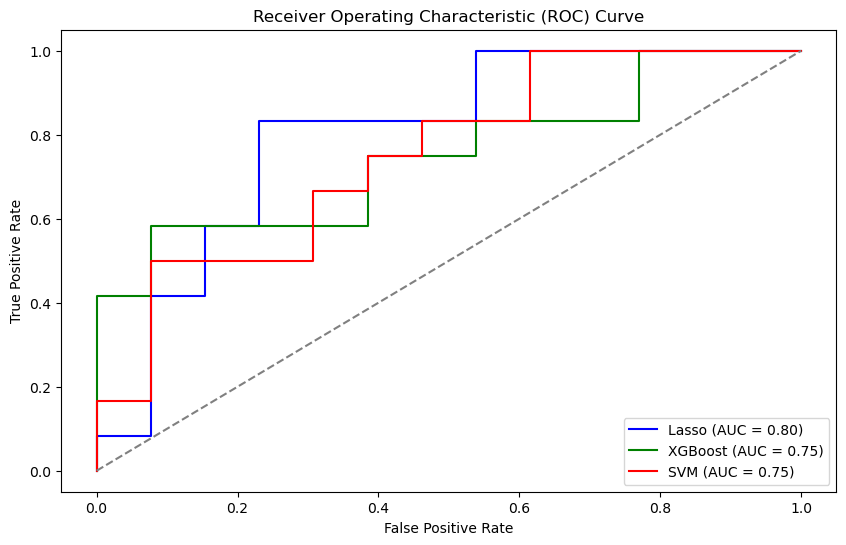

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score

# Compute ROC curve and ROC area for each model
lasso_prob = lasso_model.predict_proba(X_test)[:, 1]
xgb_prob = xgb_model.predict_proba(X_test)[:, 1]
svm_prob = svm_model.predict_proba(X_test)[:, 1]

lasso_fpr, lasso_tpr, _ = roc_curve(y_test, lasso_prob)
xgb_fpr, xgb_tpr, _ = roc_curve(y_test, xgb_prob)
svm_fpr, svm_tpr, _ = roc_curve(y_test, svm_prob)

lasso_auc = roc_auc_score(y_test, lasso_prob)
xgb_auc = roc_auc_score(y_test, xgb_prob)
svm_auc = roc_auc_score(y_test, svm_prob)

plt.figure(figsize=(10, 6))
plt.plot(lasso_fpr, lasso_tpr, color='blue', label=f'Lasso (AUC = {lasso_auc:.2f})')
plt.plot(xgb_fpr, xgb_tpr, color='green', label=f'XGBoost (AUC = {xgb_auc:.2f})')
plt.plot(svm_fpr, svm_tpr, color='red', label=f'SVM (AUC = {svm_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()


## 5-fold

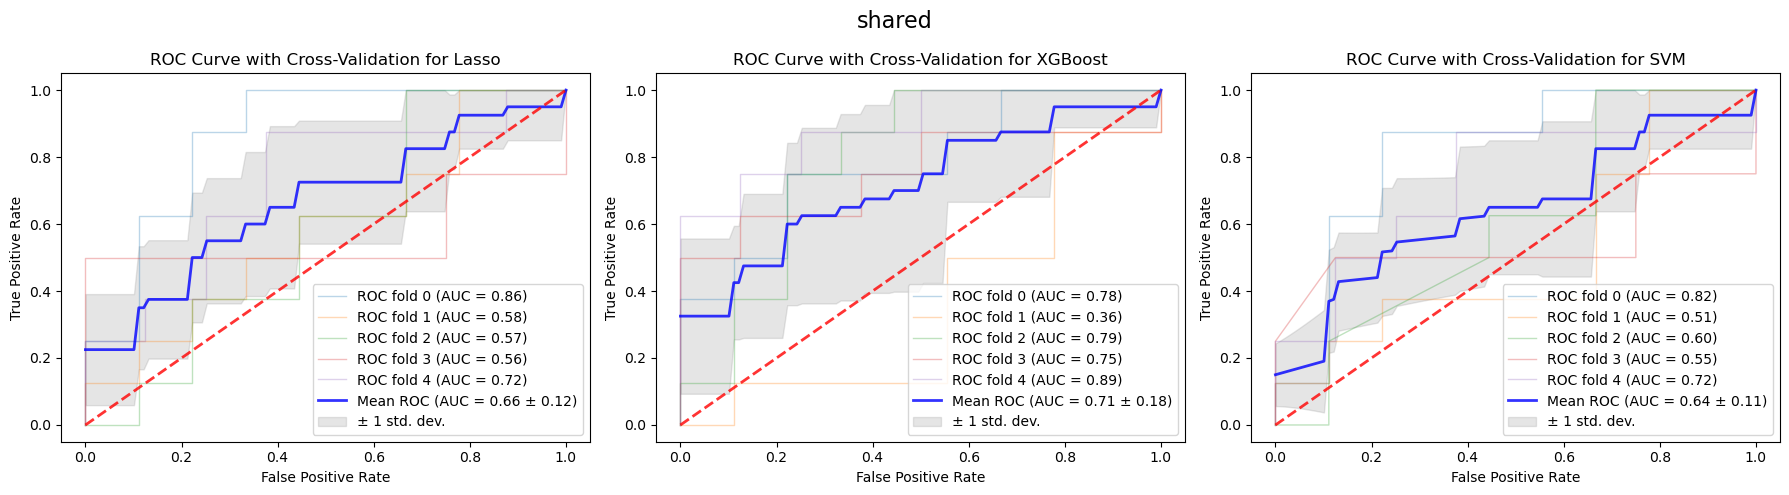

In [ ]:
from sklearn.model_selection import cross_val_predict, StratifiedKFold
from sklearn.metrics import roc_auc_score

# Prepare cross-validation
cv = StratifiedKFold(n_splits=5)

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Plot ROC curves for each classifier in subplots
plot_cv_roc_curve(lasso_model, X, y, 'Lasso', axes[0])
plot_cv_roc_curve(xgb_model, X, y, 'XGBoost', axes[1])
plot_cv_roc_curve(svm_model, X, y, 'SVM', axes[2])

plt.suptitle(selection_method,fontsize=16)
plt.tight_layout()
plt.show()



In [ ]:
sig_features['shared']

['creatinine',
 'pantothenate',
 'betaine aldehyde',
 'asparagine',
 'quinolinate',
 'uridine']

# Multilabel Classification

## Prepare Data

In [35]:
metab_df=pd.read_csv('../../../Subtype/data/Using/metab.csv',index_col=0)
sample_df=pd.read_csv('../../../Subtype/data/Using/sample.csv',index_col=0)
lipid_df=pd.read_csv('../../../Subtype/data/Using/lipid.csv',index_col=0)
# sample_df=chemical_sample_df
# sample_df.set_index("Sample Name",inplace=True)

metab_num=metab_df.shape[1]
lipid_num=lipid_df.shape[1]


In [15]:
lipid_df.shape

(106, 750)

### Sample Process

In [16]:
sample_df=pd.read_csv('../../data/Using/sample.csv')
sample_df.shape
batch_1_chemical_df=pd.read_csv('../../data/survival_sample/batch_1.csv')
batch_2_chemical_df=pd.read_csv('../../data/survival_sample/batch_2.csv')
chemical_ids=[]
chemical_ids.extend(batch_1_chemical_df['Sample Name'].values.tolist())
len(chemical_ids)
batch_2_chemical_df
hospital_ids=list(batch_2_chemical_df[batch_2_chemical_df['是否辅助化疗']==1]['住院号'].values)
batch_2_chemical_ids=sample_df.loc[sample_df['hospital_id'].isin(hospital_ids),'Sample Name']

chemical_ids.extend(batch_2_chemical_ids[~batch_2_chemical_ids.isna()].values.tolist())
chemical_sample_df=sample_df[sample_df['Sample Name'].isin(chemical_ids)]
chemical_sample_df.set_index("Sample Name",inplace=True)

In [41]:
chemical_sample_df.to_csv('chemical_sample.csv')
# chemical_sample_df.shape

(80, 25)

In [40]:
chemical_sample_df.survival_level.value_counts()

survival_level
high    38
low     31
Name: count, dtype: int64

## Metab Whole Process

In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

def init_models():
    # Lasso (Logistic Regression with L1 penalty)
    lasso_model = LogisticRegression(penalty='l1',C=1, solver='liblinear')

    # XGB
    xgb_model = XGBClassifier(
        use_label_encoder=False,
        eval_metric='logloss'
    )
    # xgb_model.fit(X_train, y_train, eval_set=[(X_test, y_test)], early_stopping_rounds=50, verbose=False)


    # SVM Model
    svm_model = SVC(kernel='linear', probability=True)
    elastic_net_model = ElasticNet()  # Add ElasticNet model initialization
    elastic_net_model = LogisticRegression(penalty='elasticnet', solver='saga', l1_ratio=0.5)
    # cox_boost_model = CoxPHFitter()   # Add CoxBoost model initialization
    return lasso_model, xgb_model, svm_model, elastic_net_model

In [38]:
low=36
high=36
survival_level=[get_survival_level(sample,low,high) for index,sample in sample_df.iterrows()]
sample_df['survival_level']=survival_level

# metab_survival_df=pd.merge(metab_df,sample_df.loc[:,['survival_level']],left_index=True,right_index=True)
survival_level=[get_survival_level(sample,low,high) for index,sample in chemical_sample_df.iterrows()]
chemical_sample_df['survival_level']=survival_level

metab_survival_df=pd.merge(metab_df,chemical_sample_df.loc[:,['survival_level']],left_index=True,right_index=True)
print(metab_survival_df.shape)

(76, 172)


In [18]:
print(sig_features['shap'])
print(sig_features['stat'])
print(sig_features['shared'])
print(len(sig_features['shared']))

NameError: name 'sig_features' is not defined

In [37]:
metab_survival_df.shape

(83, 172)

low is 36,high is 36,survival_level
high    43
low     40
Name: count, dtype: int64


KeyboardInterrupt: 

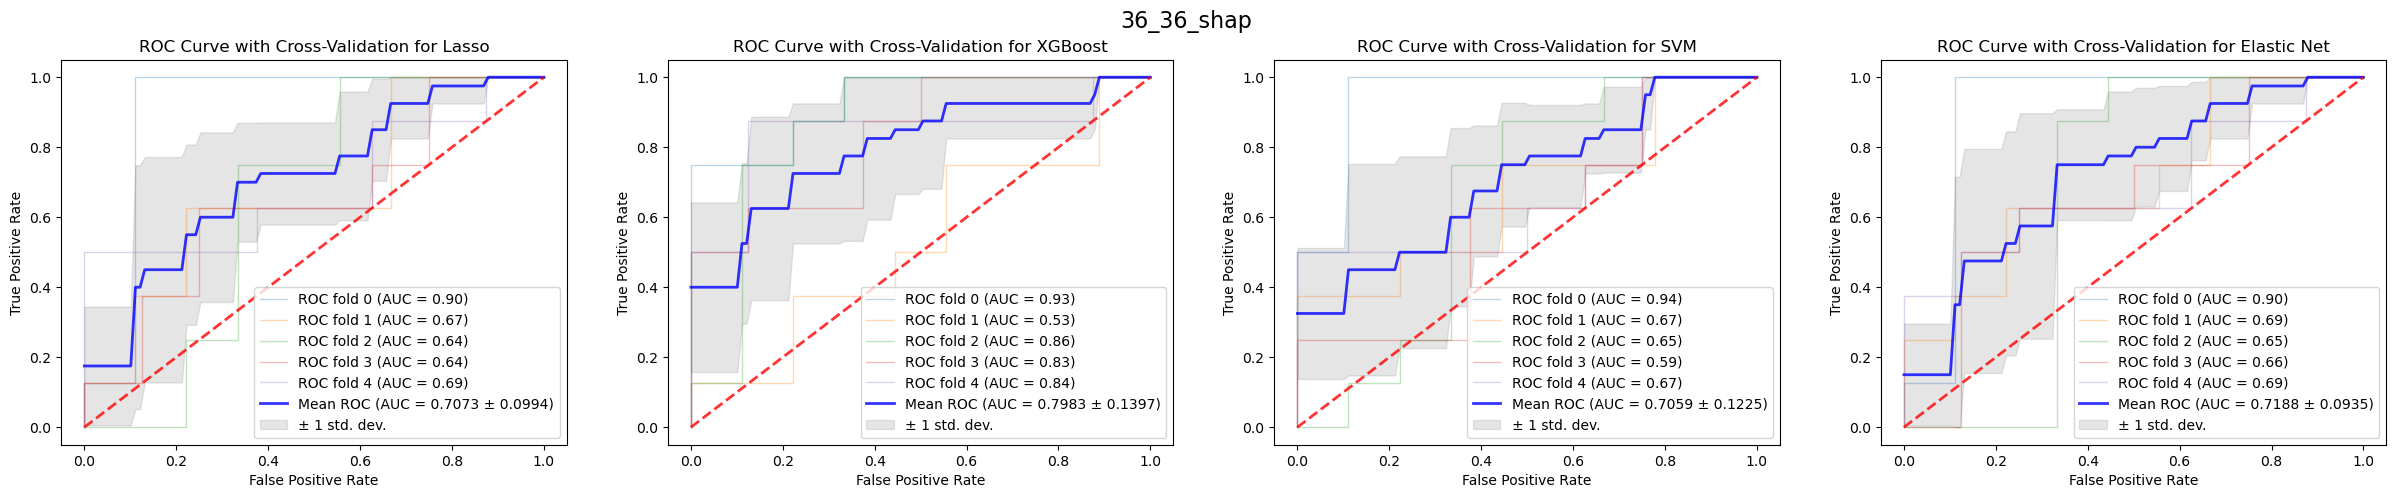

In [36]:
# 36-36 Whole Sample

low=36
high=36

survival_level=[get_survival_level(sample,low,high) for index,sample in sample_df.iterrows()]
sample_df['survival_level']=survival_level

metab_survival_df=pd.merge(metab_df,sample_df.loc[:,['survival_level']],left_index=True,right_index=True)
metab_survival_df
metab_survival_df=metab_survival_df[~metab_survival_df['survival_level'].isna()]
X = metab_survival_df.iloc[:,:metab_num]
y = metab_survival_df.loc[:,['survival_level']]
print(f"low is {low},high is {high},{y['survival_level'].value_counts()}")
# Encode Y
label_encoder = LabelEncoder()
y['survival_level'] = label_encoder.fit_transform(y)

# Scaler on X
scaler = StandardScaler()
X_array=scaler.fit_transform(X)
X=pd.DataFrame(X_array,index=X.index,columns=X.columns)

sig_features={}
sig_features['shap']=get_important_feature_by_shap(X,y,20)
sig_features['stat']=get_important_feature_by_stat(pd.merge(X,y,left_index=True,right_index=True),'survival_level')
sig_features['shared']=list(set(sig_features['shap'])&set(sig_features['stat']))

selection_method_list=sig_features.keys()
for selection_method in selection_method_list:
    
    selected_features=sig_features[selection_method]
    X = metab_survival_df.loc[:,selected_features]
    y = metab_survival_df.loc[:,['survival_level']]
    label_encoder = LabelEncoder()
    y['survival_level'] = label_encoder.fit_transform(y)

    # Scaler on X
    scaler = StandardScaler()
    X_array=scaler.fit_transform(X)
    X=pd.DataFrame(X_array,index=X.index,columns=X.columns)

    lasso_model, xgb_model, svm_model, elastic_net_model= init_models()
    # Prepare cross-validation
    cv = StratifiedKFold(n_splits=5)

    fig, axes = plt.subplots(1, 4, figsize=(30, 5))  # Adjust the number of subplots

    # Plot ROC curves for each classifier in subplots
    plot_cv_roc_curve(lasso_model, X, y, 'Lasso', axes[0])
    plot_cv_roc_curve(xgb_model, X, y, 'XGBoost', axes[1])
    plot_cv_roc_curve(svm_model, X, y, 'SVM', axes[2])
    plot_cv_roc_curve(elastic_net_model, X, y, 'Elastic Net', axes[3])  # Add ElasticNet to the plots
    # plot_cv_roc_curve(cox_boost_model, X, y, 'CoxBoost', axes[4])  # Add CoxBoost to the plots
    fig_name=str(low)+'_'+str(high)+'_'+selection_method
    plt.suptitle(fig_name,fontsize=16)
    plt.tight_layout()
    # plt.savefig(os.path.join(dirpath,fig_name+'.jpg'))



### Single Model

In [ ]:
# 36-36 Whole Sample

low=36
high=36

survival_level=[get_survival_level(sample,low,high) for index,sample in sample_df.iterrows()]
sample_df['survival_level']=survival_level

metab_survival_df=pd.merge(metab_df,sample_df.loc[:,['survival_level']],left_index=True,right_index=True)
metab_survival_df
metab_survival_df=metab_survival_df[~metab_survival_df['survival_level'].isna()]
X = metab_survival_df.iloc[:,:metab_num]
y = metab_survival_df.loc[:,['survival_level']]
print(f"low is {low},high is {high},{y['survival_level'].value_counts()}")
# Encode Y
label_encoder = LabelEncoder()
y['survival_level'] = label_encoder.fit_transform(y)

# Scaler on X
scaler = StandardScaler()
X_array=scaler.fit_transform(X)
X=pd.DataFrame(X_array,index=X.index,columns=X.columns)

sig_features={}
sig_features['shap']=get_important_feature_by_shap(X,y,20)
sig_features['stat']=get_important_feature_by_stat(pd.merge(X,y,left_index=True,right_index=True),'survival_level')
sig_features['shared']=list(set(sig_features['shap'])&set(sig_features['stat']))

selection_method_list=sig_features.keys()
for selection_method in selection_method_list:
    
    selected_features=sig_features[selection_method]
    X = metab_survival_df.loc[:,selected_features]
    y = metab_survival_df.loc[:,['survival_level']]
    label_encoder = LabelEncoder()
    y['survival_level'] = label_encoder.fit_transform(y)

    # Scaler on X
    scaler = StandardScaler()
    X_array=scaler.fit_transform(X)
    X=pd.DataFrame(X_array,index=X.index,columns=X.columns)

    lasso_model, xgb_model, svm_model, elastic_net_model= init_models()
    # Prepare cross-validation
    cv = StratifiedKFold(n_splits=5)

    fig, axes = plt.subplots(1, 4, figsize=(30, 5))  # Adjust the number of subplots

    # Plot ROC curves for each classifier in subplots
    plot_cv_roc_curve(lasso_model, X, y, 'Lasso', axes[0])
    plot_cv_roc_curve(xgb_model, X, y, 'XGBoost', axes[1])
    plot_cv_roc_curve(svm_model, X, y, 'SVM', axes[2])
    plot_cv_roc_curve(elastic_net_model, X, y, 'Elastic Net', axes[3])  # Add ElasticNet to the plots
    # plot_cv_roc_curve(cox_boost_model, X, y, 'CoxBoost', axes[4])  # Add CoxBoost to the plots
    fig_name=str(low)+'_'+str(high)+'_'+selection_method
    plt.suptitle(fig_name,fontsize=16)
    plt.tight_layout()
    # plt.savefig(os.path.join(dirpath,fig_name+'.jpg'))



low is 36,high is 36,survival_level
high    37
low     28
Name: count, dtype: int64


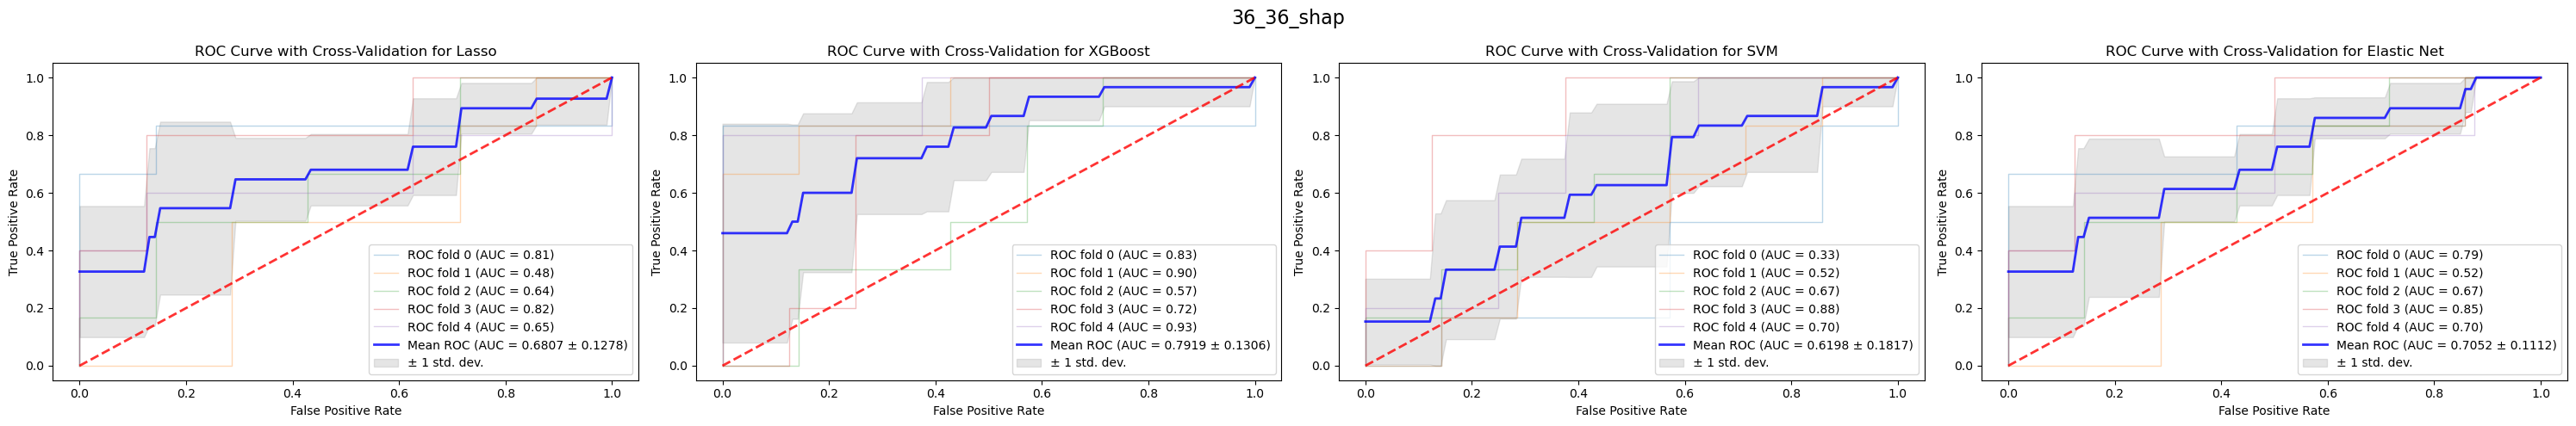

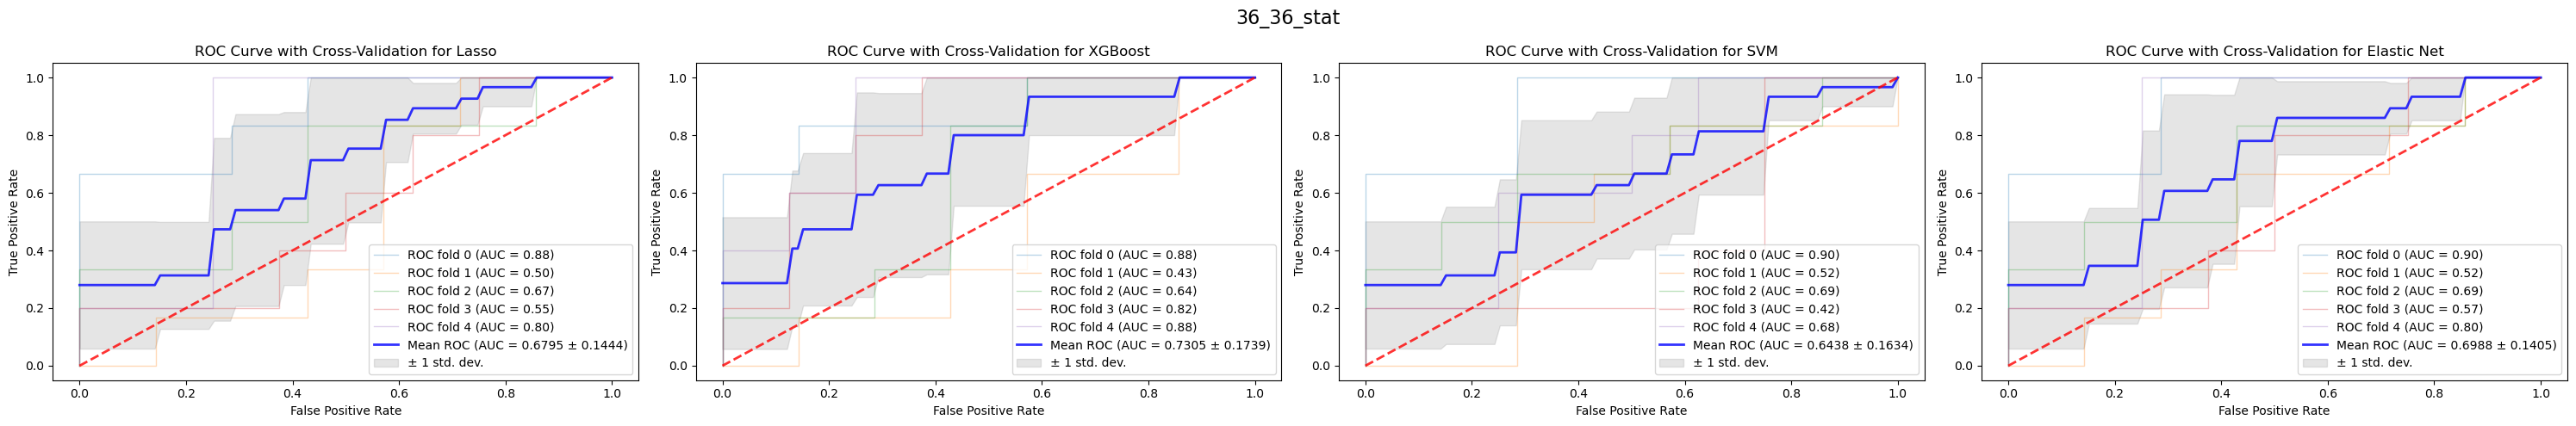

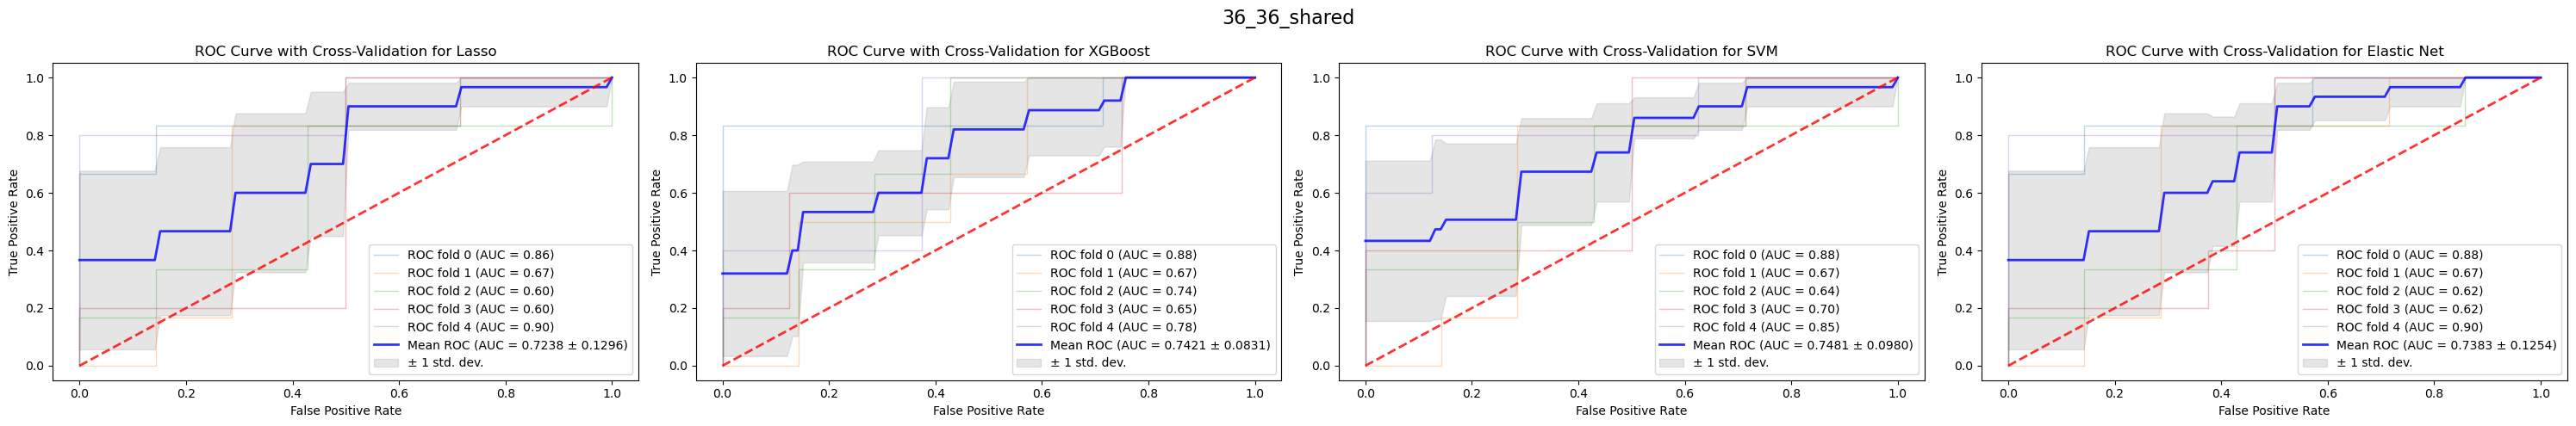

In [ ]:
# 36-36 Chemotherapy Sample

low=36
high=36

survival_level=[get_survival_level(sample,low,high) for index,sample in chemical_sample_df.iterrows()]
chemical_sample_df['survival_level']=survival_level

metab_survival_df=pd.merge(metab_df,chemical_sample_df.loc[:,['survival_level']],left_index=True,right_index=True)
metab_survival_df
metab_survival_df=metab_survival_df[~metab_survival_df['survival_level'].isna()]
X = metab_survival_df.iloc[:,:metab_num]
y = metab_survival_df.loc[:,['survival_level']]
print(f"low is {low},high is {high},{y['survival_level'].value_counts()}")
# Encode Y
label_encoder = LabelEncoder()
y['survival_level'] = label_encoder.fit_transform(y)

# Scaler on X
scaler = StandardScaler()
X_array=scaler.fit_transform(X)
X=pd.DataFrame(X_array,index=X.index,columns=X.columns)

sig_features={}
sig_features['shap']=get_important_feature_by_shap(X,y,20)
sig_features['stat']=get_important_feature_by_stat(pd.merge(X,y,left_index=True,right_index=True),'survival_level')
sig_features['shared']=list(set(sig_features['shap'])&set(sig_features['stat']))

selection_method_list=sig_features.keys()
for selection_method in selection_method_list:
    
    selected_features=sig_features[selection_method]
    X = metab_survival_df.loc[:,selected_features]
    y = metab_survival_df.loc[:,['survival_level']]
    label_encoder = LabelEncoder()
    y['survival_level'] = label_encoder.fit_transform(y)

    # Scaler on X
    scaler = StandardScaler()
    X_array=scaler.fit_transform(X)
    X=pd.DataFrame(X_array,index=X.index,columns=X.columns)

    lasso_model, xgb_model, svm_model, elastic_net_model= init_models()
    # Prepare cross-validation
    cv = StratifiedKFold(n_splits=5)

    fig, axes = plt.subplots(1, 4, figsize=(30, 5))  # Adjust the number of subplots

    # Plot ROC curves for each classifier in subplots
    plot_cv_roc_curve(lasso_model, X, y, 'Lasso', axes[0])
    plot_cv_roc_curve(xgb_model, X, y, 'XGBoost', axes[1])
    plot_cv_roc_curve(svm_model, X, y, 'SVM', axes[2])
    plot_cv_roc_curve(elastic_net_model, X, y, 'Elastic Net', axes[3])  # Add ElasticNet to the plots
    # plot_cv_roc_curve(cox_boost_model, X, y, 'CoxBoost', axes[4])  # Add CoxBoost to the plots
    fig_name=str(low)+'_'+str(high)+'_'+selection_method
    plt.suptitle(fig_name,fontsize=16)
    plt.tight_layout()
    # plt.savefig(os.path.join(dirpath,fig_name+'.jpg'))



In [ ]:
print(sig_features['shap'])
print(sig_features['stat'])
print(sig_features['shared'])
print(len(sig_features['shared']))

['creatinine', 'tyrosine', 'dump', 'aspartate', 'n-acetyl-glucosamine-1-phosphate', 'deoxyinosine', 'glutathione disulfide_neg', '2-deoxyglucose-6-phosphate', 'glycolate', 's-adenosyl-l-homocysteine_neg', 'succinate', '2-keto-isovalerate', 'p-aminobenzoate', 'fructose-6-phosphate', 'pantothenate', 'dl-pipecolic acid', 'acetyllysine', 'glycerophosphocholine', 'hydroxyproline', 'nadh_pos']
['s-adenosyl-l-homocysteine_neg', 'phenylalanine', 'aminoadipic acid', 'creatinine', 'deoxyinosine', 'uridine', '4-phosphopantothenate', 'p-aminobenzoate', 's-adenosyl-l-homocysteine_pos', 'hypoxanthine', 'methionine', 'n-acetyl-l-alanine_neg', '2-aminooctanoic acid', 'cytidine', 'pyrophosphate', 'asparagine', 'ctp', 'leucine-isoleucine']
['s-adenosyl-l-homocysteine_neg', 'deoxyinosine', 'p-aminobenzoate', 'creatinine']
4


In [ ]:
# Whole Sample
dirpath="../results/20240626_survival/whole_sample/"
os.makedirs(dirpath,exist_ok=True)
for low in [12,24,36,48]:
    for high in [24,36,48]:
        if low>high:
            continue
        survival_level=[get_survival_level(sample,low,high) for index,sample in sample_df.iterrows()]
        sample_df['survival_level']=survival_level
        
        metab_survival_df=pd.merge(metab_df,sample_df.loc[:,['survival_level']],left_index=True,right_index=True)
        metab_survival_df
        metab_survival_df=metab_survival_df[~metab_survival_df['survival_level'].isna()]
        X = metab_survival_df.iloc[:,:metab_num]
        y = metab_survival_df.loc[:,['survival_level']]
        print(f"low is {low},high is {high},{y['survival_level'].value_counts()}")
        # Encode Y
        label_encoder = LabelEncoder()
        y['survival_level'] = label_encoder.fit_transform(y)

        # Scaler on X
        scaler = StandardScaler()
        X_array=scaler.fit_transform(X)
        X=pd.DataFrame(X_array,index=X.index,columns=X.columns)

        sig_features={}
        sig_features['shap']=get_important_feature_by_shap(X,y,20)
        sig_features['stat']=get_important_feature_by_stat(pd.merge(X,y,left_index=True,right_index=True),'survival_level')
        sig_features['shared']=list(set(sig_features['shap'])&set(sig_features['stat']))

        selection_method_list=sig_features.keys()
        for selection_method in selection_method_list:
            
            selected_features=sig_features[selection_method]
            X = metab_survival_df.loc[:,selected_features]
            y = metab_survival_df.loc[:,['survival_level']]
            label_encoder = LabelEncoder()
            y['survival_level'] = label_encoder.fit_transform(y)

            # Scaler on X
            scaler = StandardScaler()
            X_array=scaler.fit_transform(X)
            X=pd.DataFrame(X_array,index=X.index,columns=X.columns)

            lasso_model, xgb_model, svm_model, elastic_net_model= init_models()
            # Prepare cross-validation
            cv = StratifiedKFold(n_splits=5)

            fig, axes = plt.subplots(1, 4, figsize=(30, 5))  # Adjust the number of subplots

            # Plot ROC curves for each classifier in subplots
            plot_cv_roc_curve(lasso_model, X, y, 'Lasso', axes[0])
            plot_cv_roc_curve(xgb_model, X, y, 'XGBoost', axes[1])
            plot_cv_roc_curve(svm_model, X, y, 'SVM', axes[2])
            plot_cv_roc_curve(elastic_net_model, X, y, 'Elastic Net', axes[3])  # Add ElasticNet to the plots
            # plot_cv_roc_curve(cox_boost_model, X, y, 'CoxBoost', axes[4])  # Add CoxBoost to the plots
            fig_name=str(low)+'_'+str(high)+'_'+selection_method
            plt.suptitle(fig_name,fontsize=16)
            plt.tight_layout()
            plt.savefig(os.path.join(dirpath,fig_name+'.jpg'))



In [ ]:
# Chemotherapy
dirpath="../results/20240626_survival/chemotherapy/"
os.makedirs(dirpath,exist_ok=True)
for low in [12,24,36,48]:
    for high in [24,36,48]:
        if low>high:
            continue
        survival_level=[get_survival_level(sample,low,high) for index,sample in chemical_sample_df.iterrows()]
        chemical_sample_df['survival_level']=survival_level
        
        metab_survival_df=pd.merge(metab_df,chemical_sample_df.loc[:,['survival_level']],left_index=True,right_index=True)
        metab_survival_df
        metab_survival_df=metab_survival_df[~metab_survival_df['survival_level'].isna()]
        X = metab_survival_df.iloc[:,:metab_num]
        y = metab_survival_df.loc[:,['survival_level']]
        print(f"low is {low},high is {high},{y['survival_level'].value_counts()}")
        # Encode Y
        label_encoder = LabelEncoder()
        y['survival_level'] = label_encoder.fit_transform(y)

        # Scaler on X
        scaler = StandardScaler()
        X_array=scaler.fit_transform(X)
        X=pd.DataFrame(X_array,index=X.index,columns=X.columns)

        sig_features={}
        sig_features['shap']=get_important_feature_by_shap(X,y,20)
        sig_features['stat']=get_important_feature_by_stat(pd.merge(X,y,left_index=True,right_index=True),'survival_level')
        sig_features['shared']=list(set(sig_features['shap'])&set(sig_features['stat']))

        selection_method_list=sig_features.keys()
        for selection_method in selection_method_list:
            
            selected_features=sig_features[selection_method]
            X = metab_survival_df.loc[:,selected_features]
            y = metab_survival_df.loc[:,['survival_level']]
            label_encoder = LabelEncoder()
            y['survival_level'] = label_encoder.fit_transform(y)

            # Scaler on X
            scaler = StandardScaler()
            X_array=scaler.fit_transform(X)
            X=pd.DataFrame(X_array,index=X.index,columns=X.columns)

            lasso_model, xgb_model, svm_model, elastic_net_model= init_models()
            # Prepare cross-validation
            cv = StratifiedKFold(n_splits=5)

            fig, axes = plt.subplots(1, 4, figsize=(30, 5))  # Adjust the number of subplots

            # Plot ROC curves for each classifier in subplots
            plot_cv_roc_curve(lasso_model, X, y, 'Lasso', axes[0])
            plot_cv_roc_curve(xgb_model, X, y, 'XGBoost', axes[1])
            plot_cv_roc_curve(svm_model, X, y, 'SVM', axes[2])
            plot_cv_roc_curve(elastic_net_model, X, y, 'Elastic Net', axes[3])  # Add ElasticNet to the plots
            # plot_cv_roc_curve(cox_boost_model, X, y, 'CoxBoost', axes[4])  # Add CoxBoost to the plots
            fig_name=str(low)+'_'+str(high)+'_'+selection_method
            plt.suptitle(fig_name,fontsize=16)
            plt.tight_layout()
            # plt.show()
            plt.savefig(os.path.join(dirpath,fig_name+'.jpg'))



### Single Model

In [ ]:
# Chemotherapy
dirpath="../../results/20240822_survival/chemotherapy/"
os.makedirs(dirpath,exist_ok=True)
for low in [12,24,36,48]:
    for high in [24,36,48]:
        if low>high:
            continue
        survival_level=[get_survival_level(sample,low,high) for index,sample in chemical_sample_df.iterrows()]
        chemical_sample_df['survival_level']=survival_level
        
        metab_survival_df=pd.merge(metab_df,chemical_sample_df.loc[:,['survival_level']],left_index=True,right_index=True)
        metab_survival_df
        metab_survival_df=metab_survival_df[~metab_survival_df['survival_level'].isna()]
        X = metab_survival_df.iloc[:,:metab_num]
        y = metab_survival_df.loc[:,['survival_level']]
        print(f"low is {low},high is {high},{y['survival_level'].value_counts()}")
        # Encode Y
        label_encoder = LabelEncoder()
        y['survival_level'] = label_encoder.fit_transform(y)

        # Scaler on X
        scaler = StandardScaler()
        X_array=scaler.fit_transform(X)
        X=pd.DataFrame(X_array,index=X.index,columns=X.columns)

        sig_features={}
        sig_features['shap']=get_important_feature_by_shap(X,y,20)
        sig_features['stat']=get_important_feature_by_stat(pd.merge(X,y,left_index=True,right_index=True),'survival_level')
        sig_features['shared']=list(set(sig_features['shap'])&set(sig_features['stat']))

        selection_method_list=sig_features.keys()
        for selection_method in selection_method_list:
            
            selected_features=sig_features[selection_method]
            X = metab_survival_df.loc[:,selected_features]
            y = metab_survival_df.loc[:,['survival_level']]
            label_encoder = LabelEncoder()
            y['survival_level'] = label_encoder.fit_transform(y)

            # Scaler on X
            scaler = StandardScaler()
            X_array=scaler.fit_transform(X)
            X=pd.DataFrame(X_array,index=X.index,columns=X.columns)

            lasso_model, xgb_model, svm_model, elastic_net_model= init_models()
            # Prepare cross-validation
            cv = StratifiedKFold(n_splits=5)

            fig, ax = plt.subplots(figsize=(8, 8))  # Adjust the number of subplots

            # Plot ROC curves for each classifier in subplots
            plot_cv_roc_curve(xgb_model, X, y, 'XGBoost', ax)
            # plot_cv_roc_curve(cox_boost_model, X, y, 'CoxBoost', axes[4])  # Add CoxBoost to the plots
            fig_name=str(low)+'_'+str(high)+'_'+selection_method
            plt.suptitle(fig_name,fontsize=16)
            plt.tight_layout()
            # plt.show()
            plt.savefig(os.path.join(dirpath,fig_name+'.jpg'))



### 24-24 Test

In [19]:
# dirpath="../results/20240626_survival/lipid_chemotherapy/"
# os.makedirs(dirpath,exist_ok=True)
low=24
high=24
survival_level=[get_survival_level(sample,low,high) for index,sample in chemical_sample_df.iterrows()]
chemical_sample_df['survival_level']=survival_level


In [20]:
metab_survival_df=pd.merge(metab_df,chemical_sample_df.loc[:,['survival_level']],left_index=True,right_index=True)
print(metab_survival_df.shape)
print(metab_df.shape)

(76, 172)
(103, 171)


In [21]:

metab_survival_df=pd.merge(metab_df,chemical_sample_df.loc[:,['survival_level']],left_index=True,right_index=True)
metab_survival_df
metab_survival_df=metab_survival_df[~metab_survival_df['survival_level'].isna()]
X = metab_survival_df.iloc[:,:metab_num]
y = metab_survival_df.loc[:,['survival_level']]
print(f"low is {low},high is {high},{y['survival_level'].value_counts()}")
# Encode Y
label_encoder = LabelEncoder()
y['survival_level'] = label_encoder.fit_transform(y)

# Scaler on X
scaler = StandardScaler()
X_array=scaler.fit_transform(X)
X=pd.DataFrame(X_array,index=X.index,columns=X.columns)

sig_features={}
sig_features['shap']=get_important_feature_by_shap(X,y,20)
sig_features['stat']=get_important_feature_by_stat(pd.merge(X,y,left_index=True,right_index=True),'survival_level')
sig_features['shared']=list(set(sig_features['shap'])&set(sig_features['stat']))
print(len(sig_features['shap']))
print(len(sig_features['stat']))
print(len(sig_features['shared']))


low is 24,high is 24,survival_level
high    54
low     18
Name: count, dtype: int64
20
21
6


In [22]:
def write_list_to_file(lst, filename):
    with open(filename, 'w') as f:
        for item in lst:
            f.write("%s\n" % item)
def read_list_from_file(filename):
    with open(filename, 'r') as f:
        lines = f.readlines()
        # Remove newline characters
        lines = [line.strip() for line in lines]
    return lines


In [23]:

method='shared'
file_name = f'metab_{method}_sig_features.txt'
write_list_to_file(sig_features[method], file_name)

method='stat'
file_name = f'metab_{method}_sig_features.txt'
write_list_to_file(sig_features[method], file_name)

method='shap'
file_name = f'metab_{method}_sig_features.txt'
write_list_to_file(sig_features[method], file_name)

In [ ]:
sig_features['shared']=read_list_from_file(file_name)

In [ ]:
selection_method_list=sig_features.keys()
for selection_method in selection_method_list:

    selected_features=sig_features[selection_method]
    X = metab_survival_df.loc[:,selected_features]
    y = metab_survival_df.loc[:,['survival_level']]
    label_encoder = LabelEncoder()
    y['survival_level'] = label_encoder.fit_transform(y)

    # Scaler on X
    scaler = StandardScaler()
    X_array=scaler.fit_transform(X)
    X=pd.DataFrame(X_array,index=X.index,columns=X.columns)

    lasso_model, xgb_model, svm_model, elastic_net_model= init_models()
    # Prepare cross-validation
    cv = StratifiedKFold(n_splits=5)

    fig, axes = plt.subplots(1, 4, figsize=(30, 5))  # Adjust the number of subplots

    # Plot ROC curves for each classifier in subplots
    plot_cv_roc_curve(lasso_model, X, y, 'Lasso', axes[0])
    plot_cv_roc_curve(xgb_model, X, y, 'XGBoost', axes[1])
    plot_cv_roc_curve(svm_model, X, y, 'SVM', axes[2])
    plot_cv_roc_curve(elastic_net_model, X, y, 'Elastic Net', axes[3])  # Add ElasticNet to the plots
    # plot_cv_roc_curve(cox_boost_model, X, y, 'CoxBoost', axes[4])  # Add CoxBoost to the plots
    fig_name=str(low)+'_'+str(high)+'_'+selection_method
    plt.suptitle(fig_name,fontsize=16)
    plt.tight_layout()
    # plt.show()



In [ ]:
for key in sig_features.keys():
    print(f"{key}: {len(sig_features[key])}")

shap: 20
stat: 21
shared: 6


In [ ]:
sig_features['shared']

['methionine',
 'acetyllysine',
 'glycerophosphocholine',
 's-adenosyl-l-homocysteine_neg',
 'fructose-1,6-bisphosphate',
 'guanine']

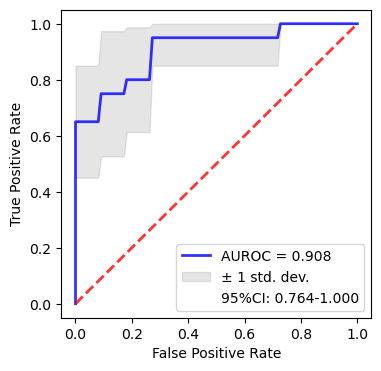

In [ ]:
selection_method="shared"
selected_features=sig_features[selection_method]
X = metab_survival_df.loc[:,selected_features]
y = metab_survival_df.loc[:,['survival_level']]
label_encoder = LabelEncoder()
y['survival_level'] = label_encoder.fit_transform(y)

# Scaler on X
scaler = StandardScaler()
X_array=scaler.fit_transform(X)
X=pd.DataFrame(X_array,index=X.index,columns=X.columns)
fig, ax = plt.subplots()
xgb_model = XGBClassifier(
        use_label_encoder=False,
        learning_rate=0.1,
        n_estimators=1000,
        max_depth=6,
        eval_metric='logloss'
    )
fig.set_figheight(4)
fig.set_figwidth(4)
classifier=xgb_model
# lasso_model, xgb_model, svm_model, elastic_net_model= init_models()
tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)

for i, (train, test) in enumerate(cv.split(X, y)):
    probas_ = classifier.fit(X.iloc[train], y.iloc[train,0].values).predict_proba(X.iloc[test])
    fpr, tpr, _ = roc_curve(y.iloc[test], probas_[:, 1])
    tprs.append(np.interp(mean_fpr, fpr, tpr))
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)
    # ax.plot(fpr, tpr, lw=1, alpha=0.3, label=f'ROC fold {i} (AUC = {roc_auc:.2f})')

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
# mean_fpr=np.insert(mean_fpr,0,0)
# mean_tpr=np.insert(mean_tpr,0,0)
mean_auc = np.mean(aucs)
std_auc = np.std(aucs)
# ax.plot(np.insert(mean_fpr,0,0), np.insert(mean_tpr,0,0), color='b',
#         label=f'AUROC = {0.908}',
#         lw=2, alpha=.8)

# std_tpr = np.std(tprs, axis=0)
# tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
# tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
# ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
#                 label='± 1 std. dev.')

# ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', alpha=.8)
# ax.set_xlabel('False Positive Rate')
# ax.set_ylabel('True Positive Rate')
# ax.set_title('')
# ax.plot([],[],' ',label='95% CI: 0.764-1.000')
# ax.legend(loc='lower right')


In [ ]:
xgb_model.get_params()

{'objective': 'binary:logistic',
 'base_score': None,
 'booster': None,
 'callbacks': None,
 'colsample_bylevel': None,
 'colsample_bynode': None,
 'colsample_bytree': None,
 'device': None,
 'early_stopping_rounds': None,
 'enable_categorical': False,
 'eval_metric': 'logloss',
 'feature_types': None,
 'gamma': None,
 'grow_policy': None,
 'importance_type': None,
 'interaction_constraints': None,
 'learning_rate': None,
 'max_bin': None,
 'max_cat_threshold': None,
 'max_cat_to_onehot': None,
 'max_delta_step': None,
 'max_depth': None,
 'max_leaves': None,
 'min_child_weight': None,
 'missing': nan,
 'monotone_constraints': None,
 'multi_strategy': None,
 'n_estimators': None,
 'n_jobs': None,
 'num_parallel_tree': None,
 'random_state': None,
 'reg_alpha': None,
 'reg_lambda': None,
 'sampling_method': None,
 'scale_pos_weight': None,
 'subsample': None,
 'tree_method': None,
 'validate_parameters': None,
 'verbosity': None,
 'use_label_encoder': False}

In [ ]:
print(len(sig_features['shap']))
sig_features['shap']


20


['5-methyl-thf',
 'fructose-1,6-bisphosphate',
 'methionine',
 'acetyllysine',
 'hydroxyproline',
 'glutathione disulfide_neg',
 'guanine',
 'adenosine',
 'glycerophosphocholine',
 's-adenosyl-l-homocysteine_neg',
 'dl-pipecolic acid',
 '4-aminobutyrate',
 'taurine',
 'uridine',
 'dtmp_neg',
 'aconitate',
 's-ribosyl-l-homocysteine_neg',
 'succinate',
 'guanosine',
 'cyclic-amp']

#### 95% CI AUROC

In [ ]:
selected_features=sig_features['shared']
X = metab_survival_df.loc[:,selected_features]
y = metab_survival_df.loc[:,['survival_level']]
label_encoder = LabelEncoder()
y['survival_level'] = label_encoder.fit_transform(y)

# Scaler on X
scaler = StandardScaler()
X_array=scaler.fit_transform(X)
X=pd.DataFrame(X_array,index=X.index,columns=X.columns)

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

def calculate_ci_auc(classifier, X, y, sig_features,n_bootstraps=10000):
    """
    Calculates the 95% confidence interval for the AUC of a classification model
    using bootstrapping.

    Args:
        classifier: Trained classification model.
        X: Features data.
        y: Target labels.
        n_bootstraps: Number of bootstrap replicates (default: 10000).

    Returns:
        A tuple containing the mean AUC and the 95% confidence interval (lower, upper).
    """
    aucs = []
    fprs = []
    tprs = []
    mean_fpr = np.linspace(0, 1, 100)


    for _ in range(n_bootstraps):
        model = XGBClassifier(
        use_label_encoder=False,
        learning_rate=0.1,
        n_estimators=1000,
        max_depth=6,
        eval_metric='logloss'
        )
        # Stratified train-test split
        # X_boot, y_boot = resample(X, y, replace=True)
        X_boot_0, y_boot_0 = resample(X[y.iloc[:,0] == 0], y[y.iloc[:,0] == 0], replace=True)
        X_boot_1, y_boot_1 = resample(X[y.iloc[:,0] == 1], y[y.iloc[:,0] == 1], replace=True)
        X_boot = pd.concat([X_boot_0, X_boot_1])
        y_boot = pd.concat([y_boot_0, y_boot_1])
        X_boot=X_boot.loc[:,sig_features]
        X_train, X_test, y_train, y_test = train_test_split(X_boot, y_boot, test_size=0.3, stratify=y_boot)
        # Evaluate model performance
        # print(f"X_train:{X_train.shape},X_test:{X_test.shape}")
        probas_ = model.fit(X_train, y_train.iloc[:,0].values).predict_proba(X_test)
        fpr, tpr, _ = roc_curve(y_test.iloc[:,0].values, probas_[:, 1])
        tprs.append(np.interp(mean_fpr, fpr, tpr))
        # print(f"fpr:{fpr.shape},tpr:{tpr.shape}")
        
        roc_auc = auc(fpr, tpr)
        aucs.append(roc_auc)

    # Calculate confidence interval (assuming normal distribution)
    confidence_level = 0.95
    alpha = 1 - confidence_level
    percentiles = [100 * alpha / 2, 100 * (1-alpha/2)]
    ci = np.percentile(aucs, percentiles)
    print(aucs)
    return fprs, tprs, aucs, ci

# ... rest of your code (functions and data)

# Calculate AUC and CI
fprs, tprs, aucs, ci_auc = calculate_ci_auc("xgb", X, y,sig_features['shared'])


In [ ]:
# write_list_to_file(fprs,"./fprs.txt")
# write_list_to_file(tprs,"./tprs.txt")
# write_list_to_file(aucs,"./aucs.txt")
# write_list_to_file(ci_aucs,"./ci_aucs.txt")

In [ ]:
mean_tpr = np.mean(tprs,axis=0)
mean_tpr[-1] = 1.0
mean_tpr[0] = 0.0
mean_fpr = np.linspace(0, 1, 100)
mean_auc=np.mean(aucs)
std_auc=np.std(aucs)
ci_aucs=np.percentile(aucs,[2.5,97.5])

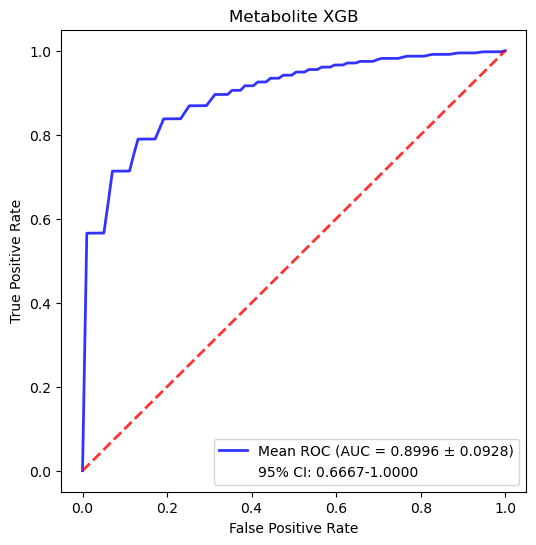

In [ ]:
fig,ax=plt.subplots()
fig.set_figheight(6)
fig.set_figwidth(6)
ax.plot(mean_fpr, mean_tpr, color='b',
        label=f'Mean ROC (AUC = {mean_auc:.4f} ± {std_auc:.4f})',
        lw=2, alpha=.8)
ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', alpha=.8)

ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.plot([],[],' ',label=f'95% CI: {ci_aucs[0]:.4f}-{ci_aucs[1]:.4f}')
ax.set_title(f'Metabolite XGB')
ax.legend(loc='lower right')

# plt.savefig("../../results/20240822_survival/chemotherapy/metab_mean_auc.pdf")

In [ ]:
X_boot_0, y_boot_0 = resample(X[y.iloc[:,0] == 0], y[y.iloc[:,0] == 0], replace=True)
X_boot_1, y_boot_1 = resample(X[y.iloc[:,0] == 1], y[y.iloc[:,0] == 1], replace=True)
X_boot = pd.concat([X_boot_0, X_boot_1])
y_boot = pd.concat([y_boot_0, y_boot_1])
X_train, X_test, y_train, y_test = train_test_split(X_boot, y_boot, test_size=0.3, stratify=y_boot)


In [ ]:
print(y_train.shape)
print(y_test.shape)
# print(X_train.shape)
# print(X_train.shape)
print(y_train['survival_level'].value_counts())
print(y_test['survival_level'].value_counts())


(50, 1)
(22, 1)
survival_level
0    37
1    13
Name: count, dtype: int64
survival_level
0    17
1     5
Name: count, dtype: int64


In [ ]:
mean_tpr = np.mean(tprs,axis=0)
mean_tpr[-1] = 1.0
mean_tpr[0] = 0.0
mean_fpr = np.linspace(0, 1, 100)

In [ ]:
fig,ax=plt.subplots()
fig.set_figheight(6)
fig.set_figwidth(6)
ax.plot(mean_fpr, mean_tpr, color='b',
        label=f'Mean ROC (AUC = {mean_auc:.4f} ± {std_auc:.4f})',
        lw=2, alpha=.8)
ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', alpha=.8)

ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.plot([],[],' ',label=f'95% CI: {ci_aucs[0]:.4f}-{ci_aucs[1]:.4f}')
ax.set_title(f'')
ax.legend(loc='lower right')

plt.savefig("../results/20240626_survival/chemotherapy/mean_auc.pdf")

#### Visualization

['high', 'low']
{'acetyllysine': 0.01762829720075709, 'fructose-1,6-bisphosphate': 0.045904978763642384, 'methionine': 0.002100926732323505, 's-adenosyl-l-homocysteine_neg': 0.005495167449682717, 'glycerophosphocholine': 0.02938625415423725, 'guanine': 0.005279264698724247}


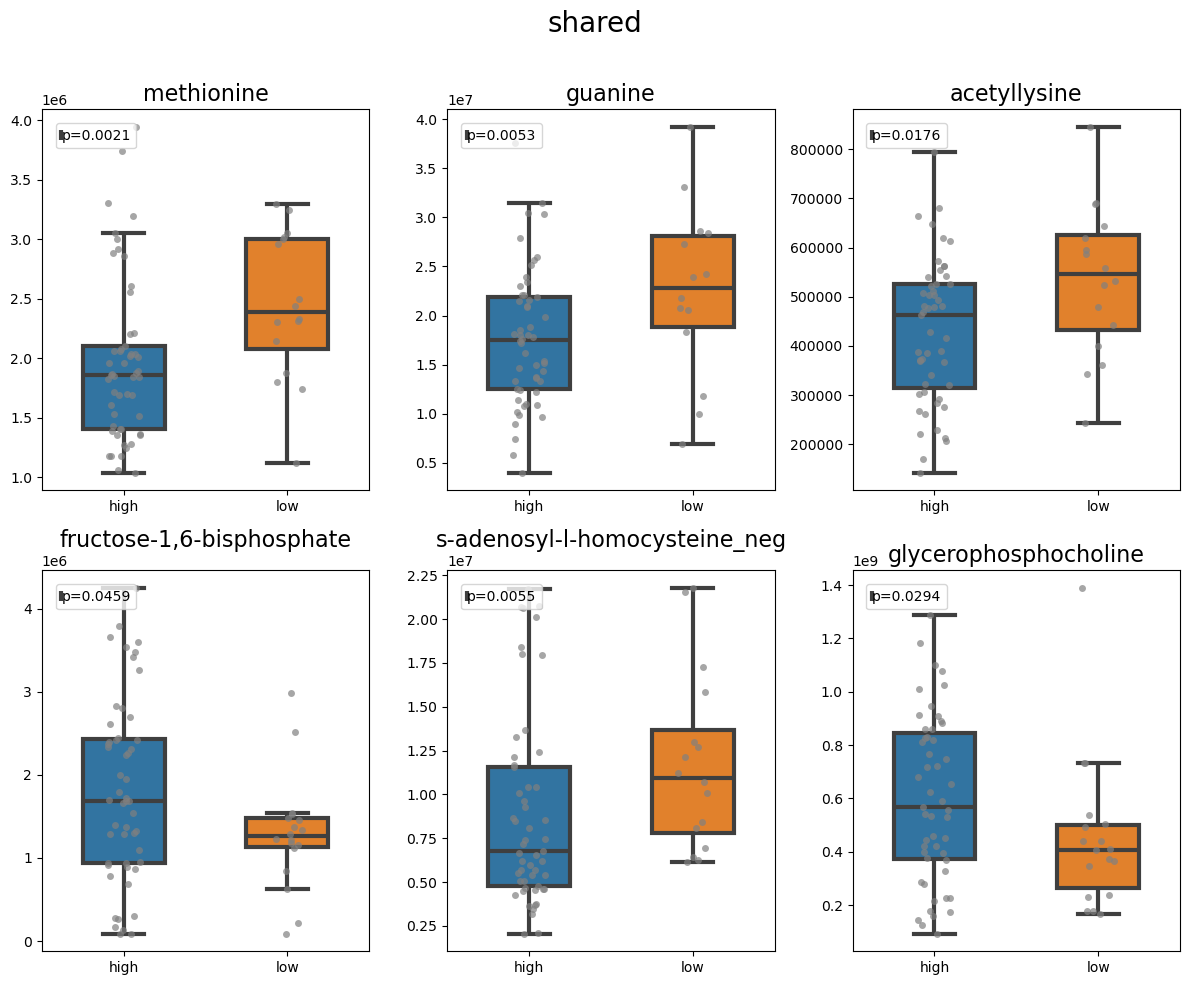

In [27]:
using_df=pd.merge(metab_df,chemical_sample_df,left_index=True,right_index=True)
selection_method='shared'

draw_box(using_df,sig_features[selection_method],class_label='survival_level')

In [24]:
selection_method='stat'

draw_box(using_df,sig_features[selection_method],class_label='survival_level')

NameError: name 'using_df' is not defined

## Lipid Whole Process

### Chemotherapy whole

In [ ]:
# Chemotherapy
dirpath="../../results/20240822_survival/lipid_chemotherapy/"
os.makedirs(dirpath,exist_ok=True)
for low in [12,24,36,48]:
    for high in [24,36,48]:
        if low>high:
            continue
        survival_level=[get_survival_level(sample,low,high) for index,sample in chemical_sample_df.iterrows()]
        chemical_sample_df['survival_level']=survival_level
        
        lipid_survival_df=pd.merge(lipid_df,chemical_sample_df.loc[:,['survival_level']],left_index=True,right_index=True)
        lipid_survival_df
        lipid_survival_df=lipid_survival_df[~lipid_survival_df['survival_level'].isna()]
        X = lipid_survival_df.iloc[:,:lipid_num]
        y = lipid_survival_df.loc[:,['survival_level']]
        print(f"low is {low},high is {high},{y['survival_level'].value_counts()}")
        # Encode Y
        label_encoder = LabelEncoder()
        y['survival_level'] = label_encoder.fit_transform(y)

        # Scaler on X
        scaler = StandardScaler()
        X_array=scaler.fit_transform(X)
        X=pd.DataFrame(X_array,index=X.index,columns=X.columns)

        sig_features={}
        sig_features['shap']=get_important_feature_by_shap(X,y,20)
        sig_features['stat']=get_important_feature_by_stat(pd.merge(X,y,left_index=True,right_index=True),'survival_level')
        sig_features['shared']=list(set(sig_features['shap'])&set(sig_features['stat']))

        selection_method_list=sig_features.keys()
        for selection_method in selection_method_list:
            
            selected_features=sig_features[selection_method]
            X = lipid_survival_df.loc[:,selected_features]
            y = lipid_survival_df.loc[:,['survival_level']]
            label_encoder = LabelEncoder()
            y['survival_level'] = label_encoder.fit_transform(y)

            # Scaler on X
            scaler = StandardScaler()
            X_array=scaler.fit_transform(X)
            X=pd.DataFrame(X_array,index=X.index,columns=X.columns)

            lasso_model, xgb_model, svm_model, elastic_net_model= init_models()
            # Prepare cross-validation
            cv = StratifiedKFold(n_splits=5)

            fig, ax = plt.subplots(figsize=(8, 8))  # Adjust the number of subplots

            # Plot ROC curves for each classifier in subplots
            plot_cv_roc_curve(xgb_model, X, y, 'XGBoost', ax)
            # plot_cv_roc_curve(cox_boost_model, X, y, 'CoxBoost', axes[4])  # Add CoxBoost to the plots
            fig_name=str(low)+'_'+str(high)+'_'+selection_method
            plt.suptitle(fig_name,fontsize=16)
            plt.tight_layout()
            # plt.show()
            plt.savefig(os.path.join(dirpath,fig_name+'.jpg'))



In [ ]:
# Chemotherapy
dirpath="../results/20240626_survival/lipid_chemotherapy/"
os.makedirs(dirpath,exist_ok=True)
for low in [12,24,36,48]:
    for high in [24,36,48]:
        if low>high:
            continue
        survival_level=[get_survival_level(sample,low,high) for index,sample in chemical_sample_df.iterrows()]
        chemical_sample_df['survival_level']=survival_level
        
        lipid_survival_df=pd.merge(lipid_df,chemical_sample_df.loc[:,['survival_level']],left_index=True,right_index=True)
        lipid_survival_df
        lipid_survival_df=lipid_survival_df[~lipid_survival_df['survival_level'].isna()]
        X = lipid_survival_df.iloc[:,:lipid_num]
        y = lipid_survival_df.loc[:,['survival_level']]
        print(f"low is {low},high is {high},{y['survival_level'].value_counts()}")
        # Encode Y
        label_encoder = LabelEncoder()
        y['survival_level'] = label_encoder.fit_transform(y)

        # Scaler on X
        scaler = StandardScaler()
        X_array=scaler.fit_transform(X)
        X=pd.DataFrame(X_array,index=X.index,columns=X.columns)

        sig_features={}
        sig_features['shap']=get_important_feature_by_shap(X,y,20)
        sig_features['stat']=get_important_feature_by_stat(pd.merge(X,y,left_index=True,right_index=True),'survival_level')
        sig_features['shared']=list(set(sig_features['shap'])&set(sig_features['stat']))
        print(len(sig_features['shap']))
        print(len(sig_features['stat']))
        print(len(sig_features['shared']))
        selection_method_list=sig_features.keys()
        for selection_method in selection_method_list:
            
            selected_features=sig_features[selection_method]
            X = lipid_survival_df.loc[:,selected_features]
            y = lipid_survival_df.loc[:,['survival_level']]
            label_encoder = LabelEncoder()
            y['survival_level'] = label_encoder.fit_transform(y)

            # Scaler on X
            scaler = StandardScaler()
            X_array=scaler.fit_transform(X)
            X=pd.DataFrame(X_array,index=X.index,columns=X.columns)

            lasso_model, xgb_model, svm_model, elastic_net_model= init_models()
            # Prepare cross-validation
            cv = StratifiedKFold(n_splits=5)

            fig, axes = plt.subplots(1, 4, figsize=(30, 5))  # Adjust the number of subplots

            # Plot ROC curves for each classifier in subplots
            plot_cv_roc_curve(lasso_model, X, y, 'Lasso', axes[0])
            plot_cv_roc_curve(xgb_model, X, y, 'XGBoost', axes[1])
            plot_cv_roc_curve(svm_model, X, y, 'SVM', axes[2])
            plot_cv_roc_curve(elastic_net_model, X, y, 'Elastic Net', axes[3])  # Add ElasticNet to the plots
            # plot_cv_roc_curve(cox_boost_model, X, y, 'CoxBoost', axes[4])  # Add CoxBoost to the plots
            fig_name=str(low)+'_'+str(high)+'_'+selection_method
            plt.suptitle(fig_name,fontsize=16)
            plt.tight_layout()
            # plt.show()
            # plt.savefig(os.path.join(dirpath,fig_name+'.jpg'))



In [ ]:
print(len(sig_features['shap']))
print(len(sig_features['stat']))
print(len(sig_features['shared']))

20
31
5


### 24-24 Test

In [29]:
# dirpath="../results/20240626_survival/lipid_chemotherapy/"
# os.makedirs(dirpath,exist_ok=True)
low=24
high=24
survival_level=[get_survival_level(sample,low,high) for index,sample in chemical_sample_df.iterrows()]
chemical_sample_df['survival_level']=survival_level


In [30]:
lipid_survival_df=pd.merge(lipid_df,chemical_sample_df.loc[:,['survival_level']],left_index=True,right_index=True)
print(lipid_survival_df.shape)
print(lipid_df.shape)

(80, 751)
(106, 750)


In [31]:

lipid_survival_df=pd.merge(lipid_df,chemical_sample_df.loc[:,['survival_level']],left_index=True,right_index=True)
lipid_survival_df
lipid_survival_df=lipid_survival_df[~lipid_survival_df['survival_level'].isna()]
X = lipid_survival_df.iloc[:,:lipid_num]
y = lipid_survival_df.loc[:,['survival_level']]
print(f"low is {low},high is {high},{y['survival_level'].value_counts()}")
# Encode Y
label_encoder = LabelEncoder()
y['survival_level'] = label_encoder.fit_transform(y)

# Scaler on X
scaler = StandardScaler()
X_array=scaler.fit_transform(X)
X=pd.DataFrame(X_array,index=X.index,columns=X.columns)

sig_features={}
sig_features['shap']=get_important_feature_by_shap(X,y,20)
sig_features['stat']=get_important_feature_by_stat(pd.merge(X,y,left_index=True,right_index=True),'survival_level')
sig_features['shared']=list(set(sig_features['shap'])&set(sig_features['stat']))
print(len(sig_features['shap']))
print(len(sig_features['stat']))
print(len(sig_features['shared']))


low is 24,high is 24,survival_level
high    55
low     21
Name: count, dtype: int64
20
52
9


In [ ]:

lipid_survival_df=pd.merge(lipid_df,chemical_sample_df.loc[:,['survival_level']],left_index=True,right_index=True)
lipid_survival_df
lipid_survival_df=lipid_survival_df[~lipid_survival_df['survival_level'].isna()]
X = lipid_survival_df.iloc[:,:lipid_num]
y = lipid_survival_df.loc[:,['survival_level']]
print(f"low is {low},high is {high},{y['survival_level'].value_counts()}")
# Encode Y
label_encoder = LabelEncoder()
y['survival_level'] = label_encoder.fit_transform(y)

# Scaler on X
scaler = StandardScaler()
X_array=scaler.fit_transform(X)
X=pd.DataFrame(X_array,index=X.index,columns=X.columns)

sig_features={}
sig_features['shap']=get_important_feature_by_shap(X,y,20)
sig_features['stat']=get_important_feature_by_stat(pd.merge(X,y,left_index=True,right_index=True),'survival_level')
sig_features['shared']=list(set(sig_features['shap'])&set(sig_features['stat']))
print(len(sig_features['shap']))
print(len(sig_features['stat']))
print(len(sig_features['shared']))


In [32]:

method='shared'
file_name = f'lipid_{method}_sig_features.txt'
write_list_to_file(sig_features[method], file_name)

method='stat'
file_name = f'lipid_{method}_sig_features.txt'
write_list_to_file(sig_features[method], file_name)

method='shap'
file_name = f'lipid_{method}_sig_features.txt'
write_list_to_file(sig_features[method], file_name)

In [ ]:
selection_method_list=sig_features.keys()
for selection_method in selection_method_list:

    selected_features=sig_features[selection_method]
    X = lipid_survival_df.loc[:,selected_features]
    y = lipid_survival_df.loc[:,['survival_level']]
    label_encoder = LabelEncoder()
    y['survival_level'] = label_encoder.fit_transform(y)

    # Scaler on X
    scaler = StandardScaler()
    X_array=scaler.fit_transform(X)
    X=pd.DataFrame(X_array,index=X.index,columns=X.columns)

    lasso_model, xgb_model, svm_model, elastic_net_model= init_models()
    # Prepare cross-validation
    cv = StratifiedKFold(n_splits=5)

    fig, axes = plt.subplots(1, 4, figsize=(30, 5))  # Adjust the number of subplots

    # Plot ROC curves for each classifier in subplots
    plot_cv_roc_curve(lasso_model, X, y, 'Lasso', axes[0])
    plot_cv_roc_curve(xgb_model, X, y, 'XGBoost', axes[1])
    plot_cv_roc_curve(svm_model, X, y, 'SVM', axes[2])
    plot_cv_roc_curve(elastic_net_model, X, y, 'Elastic Net', axes[3])  # Add ElasticNet to the plots
    # plot_cv_roc_curve(cox_boost_model, X, y, 'CoxBoost', axes[4])  # Add CoxBoost to the plots
    fig_name=str(low)+'_'+str(high)+'_'+selection_method
    plt.suptitle(fig_name,fontsize=16)
    plt.tight_layout()
    # plt.show()



In [ ]:
lipid_df.shape

(106, 750)

In [ ]:
for key in sig_features.keys():
    print(f"{key}: {len(sig_features[key])}")

shap: 20
stat: 52
shared: 9


In [ ]:
sig_features={}

In [ ]:
sig_features['shared']

['PC(34:4)',
 'PE(20:1e_22:6)',
 'PE(24:5e)',
 'PG(18:1_18:1)',
 'TG(18:0e_18:0_22:4)',
 'SM(d44:3)',
 'PE(20:0p_20:4)',
 'LPE(20:4)',
 'PC(32:0)']

In [ ]:
from sklearn.utils import resample

def calculate_ci_classification(model, X, y, n_bootstraps=1000):
    """
    Calculates the 95% confidence interval for a classification model's performance
    using bootstrapping.

    Args:
        model: Trained classification model.
        X: Features data.
        y: Target labels.
        n_bootstraps: Number of bootstrap replicates (default: 1000).

    Returns:
        A tuple containing the mean score and the 95% confidence interval (lower, upper).
    """

    scores = []
    for _ in range(n_bootstraps):
        # Resample data with replacement
        X_boot, y_boot = resample(X, y, replace=True)
        # Evaluate model performance on the resampled data
        score = model.score(X_boot, y_boot)
        scores.append(score)

    # Calculate confidence interval (assuming normal distribution)
    confidence_level = 0.95
    alpha = 1 - confidence_level
    percentiles = [100 * alpha / 2, 100 * (1 - alpha / 2)]
    ci = np.percentile(scores, percentiles)

    return np.mean(scores), ci



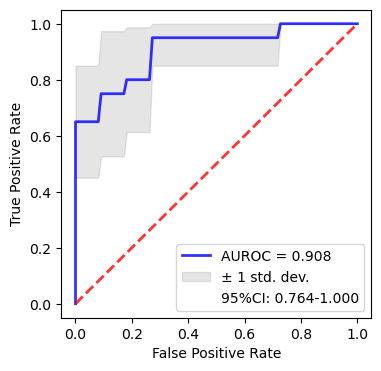

In [ ]:
selection_method="shared"
selected_features=sig_features[selection_method]
X = lipid_survival_df.loc[:,selected_features]
y = lipid_survival_df.loc[:,['survival_level']]
label_encoder = LabelEncoder()
y['survival_level'] = label_encoder.fit_transform(y)

# Scaler on X
scaler = StandardScaler()
X_array=scaler.fit_transform(X)
X=pd.DataFrame(X_array,index=X.index,columns=X.columns)
fig, ax = plt.subplots()
xgb_model = XGBClassifier(
        use_label_encoder=False,
        learning_rate=0.1,
        n_estimators=1000,
        max_depth=6,
        eval_metric='logloss'
    )
fig.set_figheight(4)
fig.set_figwidth(4)
classifier=xgb_model
# lasso_model, xgb_model, svm_model, elastic_net_model= init_models()
tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)

for i, (train, test) in enumerate(cv.split(X, y)):
    probas_ = classifier.fit(X.iloc[train], y.iloc[train,0].values).predict_proba(X.iloc[test])
    fpr, tpr, _ = roc_curve(y.iloc[test], probas_[:, 1])
    tprs.append(np.interp(mean_fpr, fpr, tpr))
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)
    # ax.plot(fpr, tpr, lw=1, alpha=0.3, label=f'ROC fold {i} (AUC = {roc_auc:.2f})')

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
# mean_fpr=np.insert(mean_fpr,0,0)
# mean_tpr=np.insert(mean_tpr,0,0)
mean_auc = np.mean(aucs)
std_auc = np.std(aucs)
ax.plot(np.insert(mean_fpr,0,0), np.insert(mean_tpr,0,0), color='b',
        label=f'AUROC = {0.908}',
        lw=2, alpha=.8)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                label='± 1 std. dev.')

ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', alpha=.8)
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('')
ax.plot([],[],' ',label='95% CI: 0.764-1.000')
ax.legend(loc='lower right')


In [ ]:
mean_tpr

array([0.65, 0.65, 0.65, 0.65, 0.65, 0.65, 0.65, 0.65, 0.65, 0.75, 0.75,
       0.75, 0.75, 0.75, 0.75, 0.75, 0.75, 0.75, 0.8 , 0.8 , 0.8 , 0.8 ,
       0.8 , 0.8 , 0.8 , 0.8 , 0.8 , 0.95, 0.95, 0.95, 0.95, 0.95, 0.95,
       0.95, 0.95, 0.95, 0.95, 0.95, 0.95, 0.95, 0.95, 0.95, 0.95, 0.95,
       0.95, 0.95, 0.95, 0.95, 0.95, 0.95, 0.95, 0.95, 0.95, 0.95, 0.95,
       0.95, 0.95, 0.95, 0.95, 0.95, 0.95, 0.95, 0.95, 0.95, 0.95, 0.95,
       0.95, 0.95, 0.95, 0.95, 0.95, 0.95, 1.  , 1.  , 1.  , 1.  , 1.  ,
       1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  ,
       1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  ,
       1.  ])

In [ ]:
xgb_model.get_params()

{'objective': 'binary:logistic',
 'base_score': None,
 'booster': None,
 'callbacks': None,
 'colsample_bylevel': None,
 'colsample_bynode': None,
 'colsample_bytree': None,
 'device': None,
 'early_stopping_rounds': None,
 'enable_categorical': False,
 'eval_metric': 'logloss',
 'feature_types': None,
 'gamma': None,
 'grow_policy': None,
 'importance_type': None,
 'interaction_constraints': None,
 'learning_rate': None,
 'max_bin': None,
 'max_cat_threshold': None,
 'max_cat_to_onehot': None,
 'max_delta_step': None,
 'max_depth': None,
 'max_leaves': None,
 'min_child_weight': None,
 'missing': nan,
 'monotone_constraints': None,
 'multi_strategy': None,
 'n_estimators': None,
 'n_jobs': None,
 'num_parallel_tree': None,
 'random_state': None,
 'reg_alpha': None,
 'reg_lambda': None,
 'sampling_method': None,
 'scale_pos_weight': None,
 'subsample': None,
 'tree_method': None,
 'validate_parameters': None,
 'verbosity': None,
 'use_label_encoder': False}

In [ ]:
print(len(sig_features['shap']))
sig_features['shap']


20


['PG(18:1_18:1)',
 'TG(20:4_20:4_22:6)',
 'SM(d44:3)',
 'PE(20:1e_22:6)',
 'PE(18:1e_22:5)',
 'PC(36:2)',
 'LPE(20:4)',
 'PE(20:0p_20:4)',
 'LPE(22:0)',
 'PC(32:0)',
 'Cer(d16:0_18:1)',
 'TG(18:0e_18:0_22:4)',
 'LPC(16:2e)',
 'Hex1Cer(d18:1_22:0)',
 'TG(8:0_8:0_8:0)',
 'PC(34:4)',
 'PC(40:9)',
 'TG(16:0_18:1_23:0)',
 'PE(24:5e)',
 'Cer(d18:2_22:0+O)']

In [ ]:
for i, (train, test) in enumerate(cv.split(X, y)):
    print(train)

[12 13 14 15 16 17 18 19 20 21 22 23 24 27 30 31 32 33 34 35 36 37 38 39
 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63
 64 65 66 67 68 69 70 71 72 73 74 75]
[ 0  1  2  3  4  5  6  7  8  9 10 11 23 24 25 26 27 28 29 30 31 32 33 34
 35 36 37 38 39 40 42 44 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62
 63 64 65 66 67 68 69 70 71 72 73 74 75]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 25
 26 28 29 38 39 40 41 42 43 44 45 46 48 49 52 53 54 55 57 58 59 60 61 62
 63 64 65 66 67 68 69 70 71 72 73 74 75]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 41 43 45 46 47 50 51 56 58 59
 60 61 63 66 67 68 69 70 71 72 73 74 75]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 62 64 65]


In [ ]:
train,test=list(enumerate(cv.split(X, y)))[0][1]

In [ ]:
for _ in range(1000):
    X_boot,y_boot=resample(X, y, replace=True)
    X_train, X_test, y_train, y_test = train_test_split(X_boot, y_boot, test_size=0.3, stratify=y)
    print(set(y_train.iloc[:,0].values))

    # print(set(X_boot.iloc[:,0].values))
    

#### 95% CI AUROC

In [27]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

def calculate_ci_auc(classifier, X, y, sig_features,n_bootstraps=10000):
    """
    Calculates the 95% confidence interval for the AUC of a classification model
    using bootstrapping.

    Args:
        classifier: Trained classification model.
        X: Features data.
        y: Target labels.
        n_bootstraps: Number of bootstrap replicates (default: 10000).

    Returns:
        A tuple containing the mean AUC and the 95% confidence interval (lower, upper).
    """
    aucs = []
    fprs = []
    tprs = []
    mean_fpr = np.linspace(0, 1, 100)


    for _ in tqdm(range(n_bootstraps)):
        model = XGBClassifier(
        use_label_encoder=False,
        learning_rate=0.1,
        n_estimators=1000,
        max_depth=6,
        eval_metric='logloss'
        )
        # Stratified train-test split
        # X_boot, y_boot = resample(X, y, replace=True)
        X_boot_0, y_boot_0 = resample(X[y.iloc[:,0] == 0], y[y.iloc[:,0] == 0], replace=True)
        X_boot_1, y_boot_1 = resample(X[y.iloc[:,0] == 1], y[y.iloc[:,0] == 1], replace=True)
        X_boot = pd.concat([X_boot_0, X_boot_1])
        y_boot = pd.concat([y_boot_0, y_boot_1])
        X_boot=X_boot.loc[:,sig_features]
        X_train, X_test, y_train, y_test = train_test_split(X_boot, y_boot, test_size=0.3, stratify=y_boot)
        # Evaluate model performance
        # print(f"X_train:{X_train.shape},X_test:{X_test.shape}")
        probas_ = model.fit(X_train, y_train.iloc[:,0].values).predict_proba(X_test)
        fpr, tpr, _ = roc_curve(y_test.iloc[:,0].values, probas_[:, 1])
        tprs.append(np.interp(mean_fpr, fpr, tpr))
        # print(f"fpr:{fpr.shape},tpr:{tpr.shape}")
        
        roc_auc = auc(fpr, tpr)
        aucs.append(roc_auc)

    # Calculate confidence interval (assuming normal distribution)
    confidence_level = 0.95
    alpha = 1 - confidence_level
    percentiles = [100 * alpha / 2, 100 * (1-alpha/2)]
    ci = np.percentile(aucs, percentiles)
    print(aucs)
    return fprs, tprs, aucs, ci

# ... rest of your code (functions and data)


In [ ]:

# Calculate AUC and CI
fprs, tprs, aucs, ci_auc = calculate_ci_auc("xgb", X, y,sig_features['shared'])


In [ ]:
X_boot_0, y_boot_0 = resample(X[y.iloc[:,0] == 0], y[y.iloc[:,0] == 0], replace=True)
X_boot_1, y_boot_1 = resample(X[y.iloc[:,0] == 1], y[y.iloc[:,0] == 1], replace=True)
X_boot = pd.concat([X_boot_0, X_boot_1])
y_boot = pd.concat([y_boot_0, y_boot_1])
X_train, X_test, y_train, y_test = train_test_split(X_boot, y_boot, test_size=0.3, stratify=y_boot)


In [ ]:
y_train.value_counts()

survival_level
0                 38
1                 15
Name: count, dtype: int64

In [ ]:
y_test.value_counts()

survival_level
0                 17
1                  6
Name: count, dtype: int64

In [ ]:
fprs=np.array(fprs)

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (10000,) + inhomogeneous part.

In [ ]:
tpr_array=np.concatenate(tprs)
fpr_array=np.concatenate(fprs)

In [ ]:
tprs=np.array(tprs,object)

In [ ]:
mean_tpr = np.mean(tprs,axis=0)
mean_tpr[-1] = 1.0
mean_tpr[0] = 0.0
mean_fpr = np.linspace(0, 1, 100)

array([0.        , 0.7259787 , 0.72605741, 0.72613611, 0.72621481,
       0.72629352, 0.81615263, 0.81621476, 0.81627689, 0.81633902,
       0.81640114, 0.81646327, 0.86685267, 0.86689763, 0.86694259,
       0.86698754, 0.8670325 , 0.86707746, 0.89793378, 0.89796871,
       0.89800365, 0.89803859, 0.89807353, 0.89810847, 0.91890739,
       0.91893851, 0.91896963, 0.91900076, 0.91903188, 0.91906301,
       0.93506265, 0.93511476, 0.93516687, 0.93521898, 0.93527109,
       0.94783886, 0.9478738 , 0.94790874, 0.94794368, 0.94797862,
       0.94801356, 0.95879614, 0.95882106, 0.95884599, 0.95887091,
       0.95889583, 0.95892076, 0.96766549, 0.96769804, 0.9677306 ,
       0.96776315, 0.96779571, 0.96782826, 0.97496187, 0.97499621,
       0.97503056, 0.9750649 , 0.97509924, 0.97513359, 0.98060783,
       0.98065076, 0.98069369, 0.98073662, 0.98077955, 0.98082247,
       0.98617472, 0.98619213, 0.98620954, 0.98622695, 0.98624436,
       0.98972911, 0.98975224, 0.98977538, 0.98979851, 0.98982

In [ ]:
mean_auc=np.mean(aucs)
std_auc=np.std(aucs)
ci_aucs=np.percentile(aucs,[2.5,97.5])

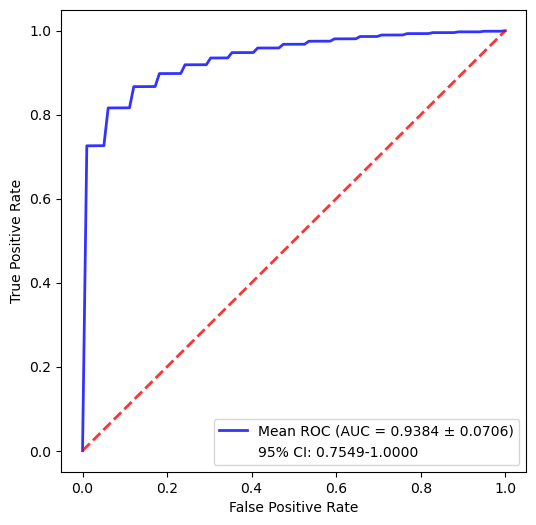

In [ ]:
fig,ax=plt.subplots()
fig.set_figheight(6)
fig.set_figwidth(6)
ax.plot(mean_fpr, mean_tpr, color='b',
        label=f'Mean ROC (AUC = {mean_auc:.4f} ± {std_auc:.4f})',
        lw=2, alpha=.8)
ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', alpha=.8)

ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.plot([],[],' ',label=f'95% CI: {ci_aucs[0]:.4f}-{ci_aucs[1]:.4f}')
ax.set_title(f'')
ax.legend(loc='lower right')

plt.savefig("../results/20240626_survival/chemotherapy/mean_auc.pdf")

#### 95% CI AUPRC

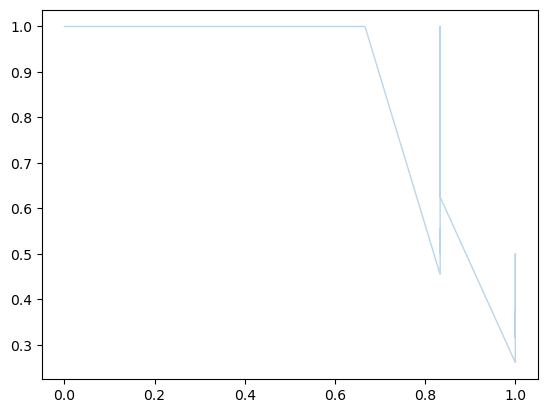

In [ ]:
xgb_model = XGBClassifier(
        use_label_encoder=False,
        learning_rate=0.1,
        n_estimators=1000,
        max_depth=6,
        eval_metric='logloss'
    )

selected_features=sig_features[selection_method]
X = lipid_survival_df.loc[:,selected_features]
y = lipid_survival_df.loc[:,['survival_level']]
label_encoder = LabelEncoder()
y['survival_level'] = label_encoder.fit_transform(y)

# Scaler on X
scaler = StandardScaler()
X_array=scaler.fit_transform(X)
X=pd.DataFrame(X_array,index=X.index,columns=X.columns)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y)
probas_ = xgb_model.fit(X_train, y_train).predict_proba(X_test)
precision, recall, thresholds = precision_recall_curve(y_test, probas_[:, 1])
sorted_indices = np.argsort(recall)
sorted_recall = np.array(recall)[sorted_indices]
sorted_precision = np.array(precision)[sorted_indices]

plt.plot(sorted_recall, sorted_precision, lw=1, alpha=0.3)


In [ ]:
xgb_model.predict(X_test)

array([0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1,
       0])

In [ ]:
probas_[:, 1]

array([0.00995908, 0.07210771, 0.03427291, 0.31433737, 0.87460274,
       0.00384694, 0.07323126, 0.00281526, 0.9865948 , 0.9727333 ,
       0.00294227, 0.9909071 , 0.01225007, 0.58438504, 0.02221281,
       0.09929778, 0.01132666, 0.01449468, 0.91955537, 0.01962927,
       0.06205714, 0.6339952 , 0.0143484 ], dtype=float32)

In [ ]:
thresholds

array([0.00281526, 0.00294227, 0.00384694, 0.00995908, 0.01132666,
       0.01225007, 0.0143484 , 0.01449468, 0.01962927, 0.02221281,
       0.03427291, 0.06205714, 0.07210771, 0.07323126, 0.09929778,
       0.31433737, 0.58438504, 0.6339952 , 0.87460274, 0.91955537,
       0.9727333 , 0.9865948 , 0.9909071 ], dtype=float32)

In [ ]:
precision

array([0.26086957, 0.27272727, 0.28571429, 0.3       , 0.31578947,
       0.33333333, 0.35294118, 0.375     , 0.4       , 0.42857143,
       0.46153846, 0.5       , 0.45454545, 0.5       , 0.55555556,
       0.625     , 0.71428571, 0.83333333, 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        ])

In [ ]:
recall

array([1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 0.83333333, 0.83333333, 0.83333333,
       0.83333333, 0.83333333, 0.83333333, 0.83333333, 0.66666667,
       0.5       , 0.33333333, 0.16666667, 0.        ])

In [ ]:
selection_method_list=sig_features.keys()
for selection_method in selection_method_list:

    selected_features=sig_features[selection_method]
    X = lipid_survival_df.loc[:,selected_features]
    y = lipid_survival_df.loc[:,['survival_level']]
    label_encoder = LabelEncoder()
    y['survival_level'] = label_encoder.fit_transform(y)

    # Scaler on X
    scaler = StandardScaler()
    X_array=scaler.fit_transform(X)
    X=pd.DataFrame(X_array,index=X.index,columns=X.columns)

    lasso_model, xgb_model, svm_model, elastic_net_model= init_models()
    # Prepare cross-validation
    cv = StratifiedKFold(n_splits=5)

    fig, axes = plt.subplots(1, 1, figsize=(16, 16))  # Adjust the number of subplots

    # Plot ROC curves for each classifier in subplots
    # plot_cv_prc_curve(lasso_model, X, y, 'Lasso', axes[0])
    plot_cv_prc_curve(xgb_model, X, y, 'XGBoost', axes)
    # plot_cv_prc_curve(svm_model, X, y, 'SVM', axes[2])
    # plot_cv_prc_curve(elastic_net_model, X, y, 'Elastic Net', axes[3])  # Add ElasticNet to the plots
    # plot_cv_prc_curve(cox_boost_model, X, y, 'CoxBoost', axes[4])  # Add CoxBoost to the plots
    fig_name=str(low)+'_'+str(high)+'_'+selection_method
    plt.suptitle(fig_name,fontsize=16)
    plt.tight_layout()
    # plt.show()



In [ ]:

def calculate_ci_prc(classifier, X, y, sig_features, n_bootstraps=10000):
    """
    Calculates the 95% confidence interval for the AUPRC of a classification model
    using bootstrapping.

    Args:
        classifier: Trained classification model.
        X: Features data.
        y: Target labels.
        n_bootstraps: Number of bootstrap replicates (default: 10000).

    Returns:
        A tuple containing the mean AUPRC and the 95% confidence interval (lower, upper).
    """
    auprcs = []
    precisions = []
    recalls = []
    mean_recall = np.linspace(0, 1, 100)

    for _ in range(n_bootstraps):
        model = XGBClassifier(
            use_label_encoder=False,
            learning_rate=0.1,
            n_estimators=1000,
            max_depth=6,
            eval_metric='logloss'
        )
        
        # Stratified train-test split with resampling
        X_boot_0, y_boot_0 = resample(X[y.iloc[:,0] == 0], y[y.iloc[:,0] == 0], replace=True)
        X_boot_1, y_boot_1 = resample(X[y.iloc[:,0] == 1], y[y.iloc[:,0] == 1], replace=True)
        X_boot = pd.concat([X_boot_0, X_boot_1])
        y_boot = pd.concat([y_boot_0, y_boot_1])
        X_boot = X_boot.loc[:, sig_features]
        
        X_train, X_test, y_train, y_test = train_test_split(X_boot, y_boot, test_size=0.3, stratify=y_boot)
        
        # Evaluate model performance
        probas_ = model.fit(X_train, y_train.iloc[:,0].values).predict_proba(X_test)
        precision, recall, _ = precision_recall_curve(y_test.iloc[:,0].values, probas_[:, 1])
        
        # Interpolate precision-recall curve
        sorted_indices = np.argsort(recall)
        sorted_recall = np.array(recall)[sorted_indices]
        sorted_precision = np.array(precision)[sorted_indices]
        interpolated_precision = np.interp(mean_recall, sorted_recall, sorted_precision)
        
        recalls.append(mean_recall)
        precisions.append(interpolated_precision)
        
        # Calculate AUPRC using the trapezoidal rule
        auprc = np.trapz(interpolated_precision, mean_recall)
        auprcs.append(auprc)
    
    # Calculate confidence interval (assuming normal distribution)
    confidence_level = 0.95
    alpha = 1 - confidence_level
    percentiles = [100 * alpha / 2, 100 * (1 - alpha / 2)]
    ci = np.percentile(auprcs, percentiles)
    
    return precisions, recalls, auprcs, ci

# Example usage

precisions, recalls, auprcs, ci = calculate_ci_prc("xgb", X, y, sig_features['shared'])
print(f"AUPRC 95% CI: {ci}")

AUPRC 95% CI: [0.59595285 0.94409002]


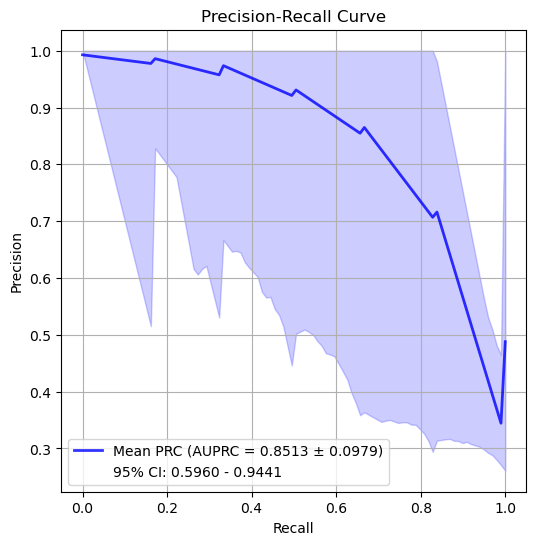

<Figure size 640x480 with 0 Axes>

In [ ]:

def plot_prc(precisions, recalls, auprcs, ci):
    # Calculate mean precision and recall
    mean_precision = np.mean(precisions, axis=0)
    mean_recall = np.linspace(0, 1, 100)
    
    # Calculate mean and standard deviation of AUPRC
    mean_auprc = np.mean(auprcs)
    std_auprc = np.std(auprcs)
    
    # Plot the mean PRC
    fig, ax = plt.subplots()
    fig.set_figheight(6)
    fig.set_figwidth(6)
    
    ax.plot(mean_recall, mean_precision, color='b',
            label=f'Mean PRC (AUPRC = {mean_auprc:.4f} ± {std_auprc:.4f})',
            lw=2, alpha=.8)
    
    # Plot the 95% confidence interval
    ci_auprcs = np.percentile(auprcs, [2.5, 97.5])
    ax.fill_between(mean_recall, np.percentile(precisions, 2.5, axis=0), np.percentile(precisions, 97.5, axis=0), color='b', alpha=.2)
    
    ax.set_xlabel('Recall')
    ax.set_ylabel('Precision')
    ax.set_title('Precision-Recall Curve')
    ax.plot([], [], ' ', label=f'95% CI: {ci_auprcs[0]:.4f} - {ci_auprcs[1]:.4f}')
    ax.legend(loc='lower left')
    
    plt.grid(True)
    plt.show()
    # Save the plot
    plt.savefig("../results/20240626_survival/chemotherapy/mean_prc.pdf")

# Example usage
plot_prc(precisions, recalls, auprcs, ci)

In [ ]:
# write_list_to_file(precisions,"./precisions.txt")
# write_list_to_file(auprcs,"./auprcs.txt")

In [ ]:
sorted_index=np.argsort(tpr_array)

In [ ]:
tpr_array[sorted_index]
fpr_array[sorted_index]

array([0.        , 0.        , 0.        , ..., 0.88235294, 1.        ,
       0.29411765])

In [ ]:
plt.plot(fpr_array[sorted_index],tpr_array[sorted_index])

In [ ]:
for item in tprs:
    print(len(item))

11
9
10
12
11
8
12
7
6
13
7
11
12
14
12
9
14
13
11
6
9
12
12
10
12
9
13
10
10
7
7
8
8
9
9
9
11
12
8
9
12
11
9
11
13
10
9
12
7
10
9
11
13
7
10
11
11
10
13
8
11
10
10
8
10
11
6
8
7
12
12
9
10
14
9
14
11
12
7
5
10
10
14
9
13
12
11
10
13
10
12
10
8
11
8
10
14
9
10
14
14
7
10
8
10
10
8
14
8
9
9
12
10
9
14
13
10
12
13
10
10
14
12
8
10
9
12
10
12
11
10
7
12
14
12
9
9
10
14
6
5
10
7
9
7
13
7
9
9
12
9
9
12
9
14
8
6
9
5
13
9
10
10
9
6
8
10
13
5
9
10
8
8
10
11
8
8
8
13
9
9
10
8
9
13
8
12
8
10
10
9
9
9
10
9
12
10
13
9
9
8
12
10
11
10
14
13
13
12
8
11
10
6
11
5
14
10
11
12
12
14
7
9
10
11
8
12
10
6
8
8
9
8
8
15
12
13
12
14
7
14
10
7
8
12
12
13
15
9
10
9
11
10
11
8
10
9
6
10
10
11
14
8
11
9
7
10
9
13
8
6
13
11
7
11
9
8
13
13
12
12
8
6
10
13
10
10
8
4
9
9
12
13
12
10
9
12
8
9
10
12
16
8
8
11
7
12
7
14
6
10
5
6
15
8
7
10
10
6
10
12
10
10
9
12
6
14
10
11
15
11
11
8
8
9
12
8
12
9
12
8
12
12
7
8
9
9
6
10
9
11
5
12
10
9
8
11
10
9
10
8
11
8
11
6
5
12
6
9
11
8
9
6
10
8
12
8
10
9
12
8
12
7
13
9
6
8
14
10
7
9

In [ ]:
np.mean(fprs,axis=0)

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (10000,) + inhomogeneous part.

<Axes: ylabel='Count'>

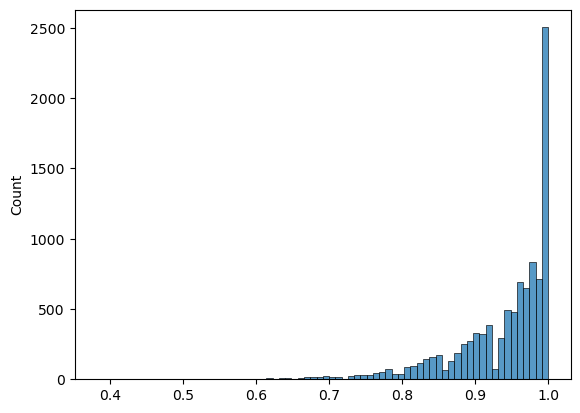

In [ ]:
sns.histplot(aucs)

In [ ]:
np.mean(aucs)

0.9377911764705883

In [ ]:
Counter(aucs)

Counter({1.0: 2670,
         0.9803921568627451: 772,
         0.9901960784313726: 586,
         0.9705882352941176: 584,
         0.9411764705882353: 520,
         0.9509803921568627: 351,
         0.9607843137254901: 345,
         0.9313725490196079: 302,
         0.9607843137254902: 271,
         0.9215686274509803: 267,
         0.9117647058823529: 257,
         0.9019607843137255: 239,
         0.8823529411764706: 226,
         0.8725490196078431: 181,
         0.8627450980392157: 152,
         0.8431372549019608: 127,
         0.8921568627450981: 121,
         0.8529411764705882: 117,
         0.9901960784313725: 112,
         0.9215686274509804: 111,
         0.892156862745098: 106,
         0.8235294117647058: 100,
         0.9509803921568628: 99,
         0.9019607843137254: 80,
         0.8627450980392156: 75,
         0.8137254901960784: 69,
         0.8333333333333334: 69,
         0.9313725490196078: 68,
         0.803921568627451: 57,
         0.7843137254901961: 51,
    

In [ ]:
np.percentile(aucs,[2.5,97.5])

array([0.74509804, 1.        ])

In [ ]:
from sklearn.linear_model import LassoCV

# Perform LASSO to select a reduced number of features
lasso = LassoCV(cv=5, random_state=0).fit(X_train, y_train.iloc[:,0].values)
selected_features = np.where(lasso.coef_ != 0)[0]
X_train_selected = X_train.iloc[:, selected_features]
X_test_selected = X_test.iloc[:, selected_features]

# Conduct fivefold cross-validation on the training set ten times with different random seeds
cv_results = []
candidate_feature_sets=[]
for seed in range(10):
    lasso_cv = LassoCV(cv=5, random_state=seed).fit(X_train_selected, y_train.iloc[:,0].values)
    cv_results.append(lasso_cv.mse_path_.mean(axis=-1))
    selected_features = X_train.columns[np.where(lasso.coef_ != 0)[0]].tolist()
    candidate_feature_sets.append(np.where(lasso_cv.coef_ != 0)[0])
# Calculate the mean and standard deviation of the cross-validation results
cv_mean = np.mean(cv_results, axis=0)
cv_std = np.std(cv_results, axis=0)

print("Selected features:", selected_features)
# print("Cross-validation mean MSE:", cv_mean)
# print("Cross-validation std MSE:", cv_std)
intersection_feature_set=candidate_feature_sets[0]
for index in range(len(candidate_feature_sets)):
    intersection_feature_set=list(set(intersection_feature_set)&set(candidate_feature_sets[index]))

Selected features: ['PG(18:1_18:1)', 'PE(18:1e_22:5)', 'LPE(22:0)', 'TG(18:0e_18:0_22:4)', 'LPC(16:2e)', 'PC(34:4)', 'PC(40:9)']


In [ ]:
intersection_feature_set

[0, 1, 2, 3, 4, 5, 6]

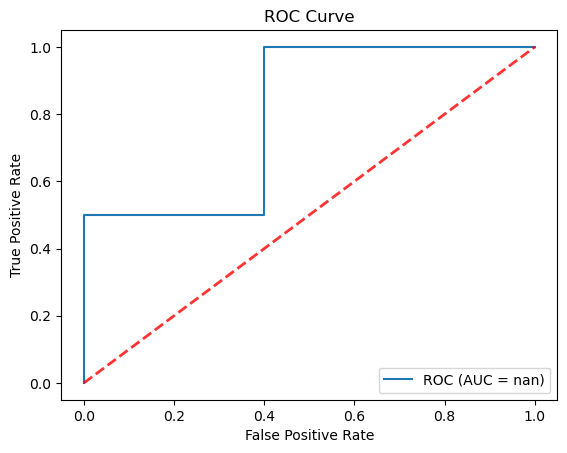

Mean AUC: nan
95% CI for AUC: [nan, nan]


In [ ]:

# Plot ROC curve
plt.plot(fprs[0], tprs[0], label=f'ROC (AUC = {mean_auc:.4f})')
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', alpha=.8)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

print(f"Mean AUC: {mean_auc:.4f}")
print(f"95% CI for AUC: [{ci_auc[0]:.4f}, {ci_auc[1]:.4f}]")


In [ ]:
y

,survival_level
8410,0
8711,0
8575,0
8195,1
8024,0
...,...
130010-T,0
120342-T,0
120155-T,0
222836-T,1


In [ ]:
new_tprs=[]
new_fprs=[]
for tmp in tprs:
    new_tprs.extend(tmp)
for tmp in fprs:
    new_fprs.extend(tmp)

In [ ]:
print(len(X_train),len(X_test))

60 16


#### Feature Visualization

In [ ]:
sig_features={}
sig_features['shared']=read_list_from_file("./shared_sig_features.txt")

In [34]:
using_df=pd.merge(lipid_df,chemical_sample_df,left_index=True,right_index=True)

In [ ]:
selection_method='shared'

['high', 'low']
{'PG(18:1_18:1)': nan, 'SM(d44:3)': nan, 'PC(34:4)': nan, 'PE(20:1e_22:6)': nan, 'PE(20:0p_20:4)': nan, 'LPE(20:4)': nan, 'TG(18:0e_18:0_22:4)': nan, 'PC(32:0)': 0.04326184589325128, 'PE(24:5e)': nan}


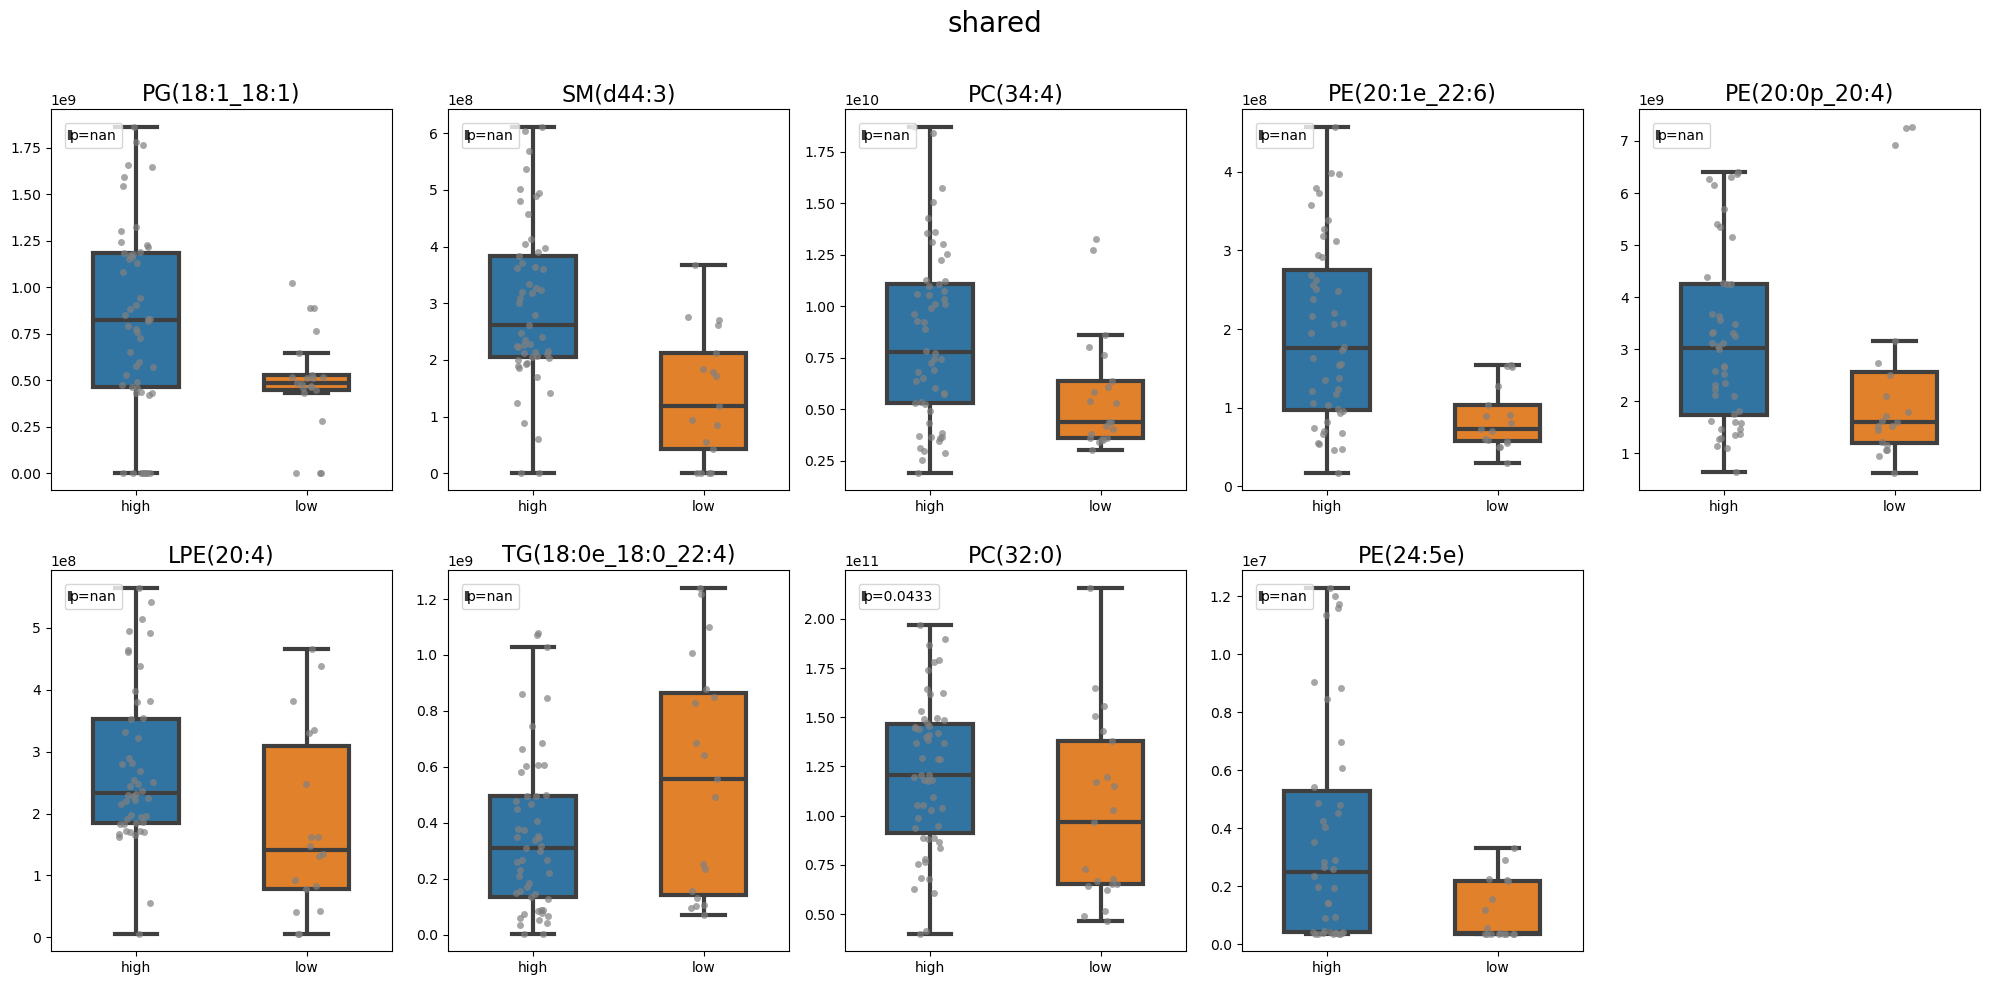

In [37]:
draw_box(using_df,sig_features[selection_method],class_label='survival_level')

## MOFA

In [22]:

import mofax as mofa
model = mofa.mofa_model("./models/lipid_only/CLL_intersection.hdf5")
factor_df=pd.DataFrame(model.get_factors())
factor_num=factor_df.shape[1]
factor_df.index=model.metadata.index
factor_df=factor_df.rename(columns={i:f"factor_{i}" for i in factor_df.columns})
factor_df


,factor_0,factor_1,factor_2,factor_3,factor_4,factor_5,factor_6,factor_7,factor_8,factor_9,factor_10,factor_11,factor_12,factor_13,factor_14
sample,,,,,,,,,,,,,,,
8410,3.152424,1.681051,2.136143,-5.175530,-0.436853,-2.677088,1.718101,1.514655,-0.375012,-1.613768,0.554462,1.377291,1.589462,-1.565118,-0.608663
8855,0.970676,-1.143893,-1.784214,-2.472857,-1.672350,1.625680,0.496481,-0.491447,-0.455214,-2.177652,-1.100830,1.338864,-2.075752,3.874600,-3.027694
8711,2.824345,-2.394764,0.706634,-2.819792,1.578378,-4.837312,-3.930728,-6.502336,6.039532,-1.973021,0.397724,3.502188,1.540432,5.714165,-2.809672
8575,0.063546,0.507328,-0.896459,-1.337116,-2.417420,0.236005,-3.311554,-1.429183,1.807676,6.723589,-2.982845,4.571072,7.912144,3.226181,1.492858
8418,-2.429297,3.395379,0.732996,-0.624542,-3.077993,-3.636772,-0.154078,-0.379683,-1.657520,-0.228540,-1.130439,-1.244124,-0.428851,-4.228737,-1.185249
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
120342-T,-5.250321,2.200767,-1.262516,-0.940172,-3.263219,-1.529124,0.920907,-1.733965,-2.324038,1.876275,0.503160,5.113908,1.031408,5.226832,-1.108586
120155-T,4.312483,-4.502420,-3.538661,-4.363959,0.118319,0.984419,1.673784,1.005722,3.886450,1.609045,3.048346,-3.613255,1.546300,2.623523,1.472312
271431-T,1.271641,-5.618099,1.893595,0.629284,2.680249,3.420918,-2.136675,-0.040061,-0.811474,2.493303,-0.059685,1.826160,3.413761,-1.700493,-4.822985


In [31]:
fprs, tprs, aucs, ci_auc = calculate_ci_auc("xgb", X, y,X.columns)


X_train:(53, 15),X_test:(23, 15)
fpr:(11,),tpr:(11,)
X_train:(53, 15),X_test:(23, 15)
fpr:(9,),tpr:(9,)
X_train:(53, 15),X_test:(23, 15)
fpr:(14,),tpr:(14,)
X_train:(53, 15),X_test:(23, 15)
fpr:(12,),tpr:(12,)
X_train:(53, 15),X_test:(23, 15)
fpr:(9,),tpr:(9,)
X_train:(53, 15),X_test:(23, 15)
fpr:(11,),tpr:(11,)
X_train:(53, 15),X_test:(23, 15)
fpr:(10,),tpr:(10,)
X_train:(53, 15),X_test:(23, 15)
fpr:(11,),tpr:(11,)
X_train:(53, 15),X_test:(23, 15)
fpr:(10,),tpr:(10,)
X_train:(53, 15),X_test:(23, 15)
fpr:(11,),tpr:(11,)
X_train:(53, 15),X_test:(23, 15)
fpr:(9,),tpr:(9,)
X_train:(53, 15),X_test:(23, 15)
fpr:(9,),tpr:(9,)
X_train:(53, 15),X_test:(23, 15)
fpr:(11,),tpr:(11,)
X_train:(53, 15),X_test:(23, 15)
fpr:(11,),tpr:(11,)
X_train:(53, 15),X_test:(23, 15)
fpr:(9,),tpr:(9,)
X_train:(53, 15),X_test:(23, 15)
fpr:(6,),tpr:(6,)
X_train:(53, 15),X_test:(23, 15)
fpr:(8,),tpr:(8,)
X_train:(53, 15),X_test:(23, 15)
fpr:(11,),tpr:(11,)
X_train:(53, 15),X_test:(23, 15)
fpr:(10,),tpr:(10,)
X_train

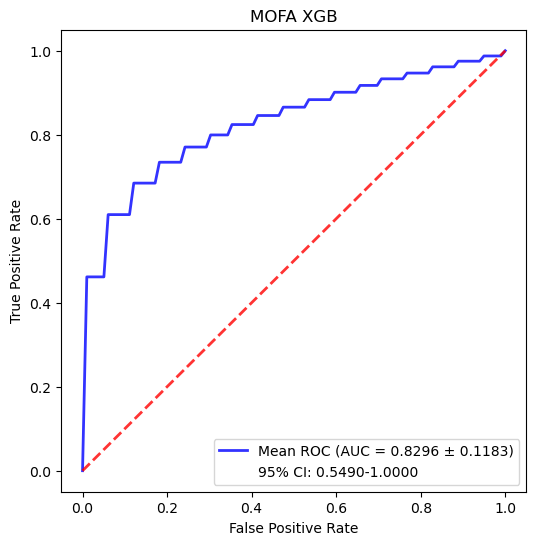

In [34]:
mean_tpr = np.mean(tprs,axis=0)
mean_tpr[-1] = 1.0
mean_tpr[0] = 0.0
mean_fpr = np.linspace(0, 1, 100)
mean_auc=np.mean(aucs)
std_auc=np.std(aucs)
ci_aucs=np.percentile(aucs,[2.5,97.5])
fig,ax=plt.subplots()
fig.set_figheight(6)
fig.set_figwidth(6)
ax.plot(mean_fpr, mean_tpr, color='b',
        label=f'Mean ROC (AUC = {mean_auc:.4f} ± {std_auc:.4f})',
        lw=2, alpha=.8)
ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', alpha=.8)

ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.plot([],[],' ',label=f'95% CI: {ci_aucs[0]:.4f}-{ci_aucs[1]:.4f}')
ax.set_title(f'MOFA XGB')
ax.legend(loc='lower right')

# plt.savefig("../results/20240626_survival/chemotherapy/mean_auc.pdf")

low is 24,high is 24,survival_level
high    55
low     21
Name: count, dtype: int64


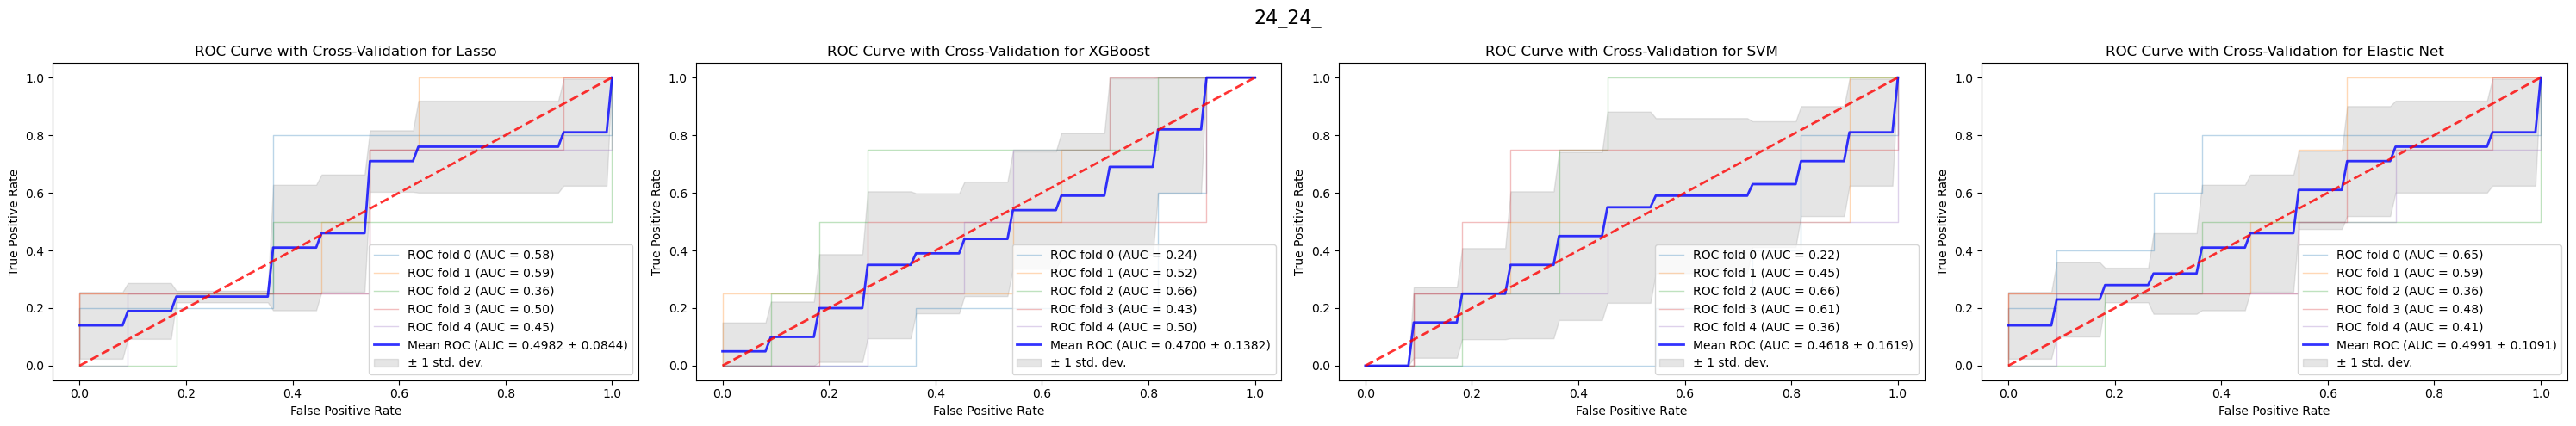

In [30]:
# Chemotherapy
dirpath="../../results/20240626_survival/mofa/"
os.makedirs(dirpath,exist_ok=True)
low=24
high = 24


survival_level=[get_survival_level(sample,low,high) for index,sample in chemical_sample_df.iterrows()]
chemical_sample_df['survival_level']=survival_level

lipid_survival_df=pd.merge(factor_df,chemical_sample_df.loc[:,['survival_level']],left_index=True,right_index=True)
lipid_survival_df
lipid_survival_df=lipid_survival_df[~lipid_survival_df['survival_level'].isna()]
X=lipid_survival_df.iloc[:,:factor_num]
y = lipid_survival_df.loc[:,['survival_level']]
print(f"low is {low},high is {high},{y['survival_level'].value_counts()}")
# Encode Y
label_encoder = LabelEncoder()
y['survival_level'] = label_encoder.fit_transform(np.array(y).ravel())

# Scaler on X
scaler = StandardScaler()
X_array=scaler.fit_transform(X)
X=pd.DataFrame(X_array,index=X.index,columns=X.columns)


y = lipid_survival_df.loc[:,['survival_level']]
label_encoder = LabelEncoder()
y['survival_level'] = label_encoder.fit_transform(y)

lasso_model, xgb_model, svm_model, elastic_net_model= init_models()
# Prepare cross-validation
cv = StratifiedKFold(n_splits=5)

fig, axes = plt.subplots(1, 4, figsize=(30, 5))  # Adjust the number of subplots

# Plot ROC curves for each classifier in subplots
plot_cv_roc_curve(lasso_model, X, y, 'Lasso', axes[0])
plot_cv_roc_curve(xgb_model, X, y, 'XGBoost', axes[1])
plot_cv_roc_curve(svm_model, X, y, 'SVM', axes[2])
plot_cv_roc_curve(elastic_net_model, X, y, 'Elastic Net', axes[3])  # Add ElasticNet to the plots
# plot_cv_roc_curve(cox_boost_model, X, y, 'CoxBoost', axes[4])  # Add CoxBoost to the plots
fig_name=str(low)+'_'+str(high)+'_'
plt.suptitle(fig_name,fontsize=16)
plt.tight_layout()
# plt.show()
# plt.savefig(os.path.join(dirpath,fig_name+'.jpg'))



# Regression

## Prepare Data

### Generate Test Data

In [24]:

# Generate synthetic dataset
np.random.seed(42)
data_size = 1000
data = {
    'age': np.random.randint(20, 80, data_size),
    'tumor_size': np.random.normal(30, 10, data_size),
    'tumor_stage': np.random.randint(1, 4, data_size),
    'os': np.random.randint(1, 60, data_size)
}
df = pd.DataFrame(data)
df['oss'] = np.random.randint(0, 2, data_size)  # 1 if the oss (death) occurred, 0 if censored

# Split the dataset
X = df[['age', 'tumor_size', 'tumor_stage']]
y = df[['os', 'oss']]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Impute missing values and standardize the features
imputer = SimpleImputer(strategy='mean')
scaler = StandardScaler()

X_train = imputer.fit_transform(X_train)
X_test = imputer.transform(X_test)

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


### Read Metab Data

In [25]:
metab_df=pd.read_csv('../../Subtype/data/Using/metab.csv',index_col=0)
sample_df=pd.read_csv('../../Subtype/data/Using/sample.csv',index_col=0)


FileNotFoundError: [Errno 2] No such file or directory: '../../Subtype/data/Using/metab.csv'

In [ ]:
metab_num=metab_df.shape[1]
metab_survival_df=pd.merge(metab_df,sample_df.loc[:,['os','oss']],left_index=True,right_index=True)
metab_survival_df

,2-aminooctanoic acid,2-deoxyglucose-6-phosphate,2-hydroxy-2-methylbutanedioic acid,2-hydroxygluterate,2-isopropylmalic acid,2-ketohexanoic acid,2-keto-isovalerate,3-phosphoglycerate,4-aminobutyrate,4-phosphopantothenate,...,urea,uric acid,uridine,utp,valine,xanthine,xanthosine,xanthurenic acid,os,oss
Sample Name,,,,,,,,,,,,,,,,,,,,,
1452,3.909210e+06,48725.024973,1.773250e+05,1.011356e+06,4.193912e+07,66616.717590,3.596227e+06,8.581937e+05,156668.169183,69880.261357,...,1.587076e+07,5.573489e+06,4.510762e+06,1.988385e+05,454142.287700,1.440208e+07,628033.701672,77677.818915,33.13,1.0
8339,5.169229e+06,44033.206972,2.617207e+05,1.451385e+06,5.336124e+07,62923.971667,1.523960e+06,1.687459e+05,562234.364331,38278.856905,...,8.616155e+06,6.514846e+06,2.352582e+06,7.673671e+06,327687.098498,3.522851e+06,136281.472333,51666.390456,9.20,1.0
5608,3.592153e+06,54593.684750,1.919383e+06,8.315796e+06,2.542946e+07,564346.486733,2.335506e+06,4.581571e+05,240041.840865,46379.599983,...,1.141479e+07,7.560250e+06,3.115865e+06,8.320128e+05,720206.665915,7.178835e+06,219414.057036,66399.033677,54.37,1.0
8232,6.226022e+06,116116.577687,2.990659e+05,1.360115e+06,5.218884e+07,189606.625485,2.253214e+06,1.862529e+06,47909.957016,49851.413253,...,1.688252e+07,1.148704e+07,2.235373e+06,5.883818e+06,431065.460887,8.751335e+06,813390.155986,61448.004721,35.97,0.0
8775,1.300326e+07,42112.787941,2.144149e+05,1.249929e+06,5.877813e+07,83032.419863,2.512204e+06,9.214721e+05,23587.333647,29061.362787,...,1.252153e+07,5.251952e+06,1.699150e+06,1.346991e+07,244224.641771,1.519282e+06,170347.746567,45850.275810,27.73,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
140143-T,4.046483e+06,54674.761372,7.220002e+05,3.170978e+06,1.884219e+07,220100.380045,1.938667e+06,6.268566e+05,130898.868300,67011.122634,...,1.124923e+07,8.791609e+06,3.304955e+06,7.899331e+05,389648.249565,8.837302e+05,145693.060274,75232.918786,30.93,1.0
190040-T,7.800576e+06,31734.608981,5.172854e+05,2.349440e+06,7.358689e+07,145821.945414,2.709849e+06,5.610590e+05,56011.981002,108680.904322,...,1.501088e+07,6.558368e+06,3.933141e+06,1.205492e+06,654250.606484,4.217668e+06,312948.071135,144943.377124,21.07,1.0
190161-T,9.307611e+06,32193.003702,2.563380e+05,1.673765e+06,6.968521e+07,122294.308498,4.225014e+06,3.728608e+05,55457.372314,35411.094167,...,8.461452e+06,3.957835e+06,1.218390e+06,7.534283e+05,270985.726738,2.025476e+06,106432.375502,58501.059802,40.13,0.0


In [ ]:
X = metab_survival_df.iloc[:,:metab_num]
y = metab_survival_df.loc[:,['os', 'oss']]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Impute missing values and standardize the features
imputer = SimpleImputer(strategy='mean')
scaler = StandardScaler()

X_train = imputer.fit_transform(X_train)
X_test = imputer.transform(X_test)

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [ ]:
print(X_train.shape)
print(X_test.shape)

(70, 171)
(31, 171)


### Model Building And Training

In [ ]:

# Cox Proportional Hazards Model
cox_df = pd.DataFrame(X_train, columns=metab_df.columns)
cox_df['os'] = y_train['os'].values
cox_df['oss'] = y_train['oss'].values

cox_model = CoxPHFitter(penalizer=0.0001)
cox_model.fit(cox_df, duration_col='os', event_col='oss')

# XGBoost Model
xgb_model = XGBRegressor(objective='survival:cox', n_estimators=100)
xgb_model.fit(X_train, y_train['os'])

# Lasso Model
lasso_model = Lasso(alpha=0.1)
lasso_model.fit(X_train, y_train['os'])

# DeepSurv Model
input_dim = X_train.shape[1]
deepsurv_model = Sequential()
deepsurv_model.add(Dense(128, input_dim=input_dim, activation='relu'))
deepsurv_model.add(Dropout(0.5))
deepsurv_model.add(Dense(64, activation='relu'))
deepsurv_model.add(Dense(1, activation='linear'))
deepsurv_model.compile(loss='mean_squared_error', optimizer='adam')

deepsurv_model.fit(X_train, y_train['os'], epochs=100, batch_size=32, verbose=0)


Your dataset has more variables than samples. Even with a penalizer (which you must use), convergence is not guaranteed.

Newton-Raphson failed to converge sufficiently. Please see the following tips in the lifelines documentation: https://lifelines.readthedocs.io/en/latest/Examples.html#problems-with-convergence-in-the-cox-proportional-hazard-model
Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.199e+01, tolerance: 8.786e+00
Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.


### Evaluation

In [ ]:
# Predictions
cox_predictions = cox_model.predict_partial_hazard(pd.DataFrame(X_test, columns=metab_df.columns))
xgb_predictions = xgb_model.predict(X_test)
lasso_predictions = lasso_model.predict(X_test)
deepsurv_predictions = deepsurv_model.predict(X_test).flatten()

y_com=y_test.copy(deep=True)
y_com['COX']=cox_predictions.values
y_com['XGB']=xgb_predictions
y_com['Lasso']=lasso_predictions
y_com['DeepSurv']=deepsurv_predictions

y_com['COX']=[100 if i>100 else i for i in y_com['COX'].values]

# Calculate C-index
cox_cindex = concordance_index(y_test['os'], -cox_predictions, y_test['oss'])
xgb_cindex = concordance_index(y_test['os'], -xgb_predictions, y_test['oss'])
lasso_cindex = concordance_index(y_test['os'], -lasso_predictions, y_test['oss'])
deepsurv_cindex = concordance_index(y_test['os'], -deepsurv_predictions, y_test['oss'])

print(f"C-index for Cox Proportional Hazards: {cox_cindex}")
print(f"C-index for XGBoost: {xgb_cindex}")
print(f"C-index for Lasso: {lasso_cindex}")
print(f"C-index for DeepSurv: {deepsurv_cindex}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
C-index for Cox Proportional Hazards: 0.4746666666666667
C-index for XGBoost: 0.544
C-index for Lasso: 0.456
C-index for DeepSurv: 0.41333333333333333


### Visualization

In [ ]:
y_com.describe()

,os,oss,COX,XGB,Lasso,DeepSurv
count,31.000000,31.000000,3.100000e+01,31.000000,31.000000,31.000000
mean,43.752903,0.677419,4.289282e+01,25.606077,38.002674,38.057362
std,35.884529,0.475191,4.747336e+01,35.718552,33.190564,23.132677
min,4.430000,0.000000,4.401386e-07,0.013549,-19.783770,9.126689
25%,19.315000,0.000000,5.225671e-03,3.013525,19.314725,20.085169
50%,33.130000,1.000000,7.664861e+00,10.122727,33.941605,33.347775
75%,51.785000,1.000000,1.000000e+02,30.099170,60.292369,49.925827
max,140.670000,1.000000,1.000000e+02,138.333710,102.690171,104.186584


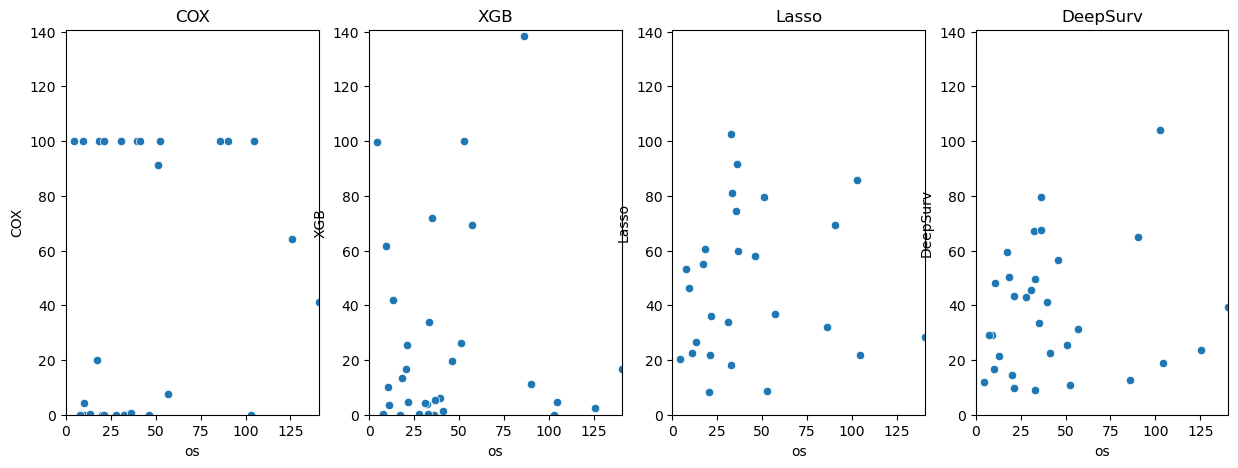

In [ ]:
g,axs=plt.subplots(1,4,figsize=(15,5))
for i in range(4):
    # g.add_subplot(1,4,i+1)
    # plt.plot(y_com['os'],y_com.iloc[:,2+i])
    ax=axs[i]
    sns.scatterplot(data=y_com,x='os',y=y_com.columns[2+i],ax=ax)
    upper_bound=max(max(y_com['os'].values),max(y_com[y_com.columns[2+i]].values))
    ax.set_title(y_com.columns[2+i])
    ax.set_xlim(0,upper_bound)
    ax.set_ylim(0,upper_bound)

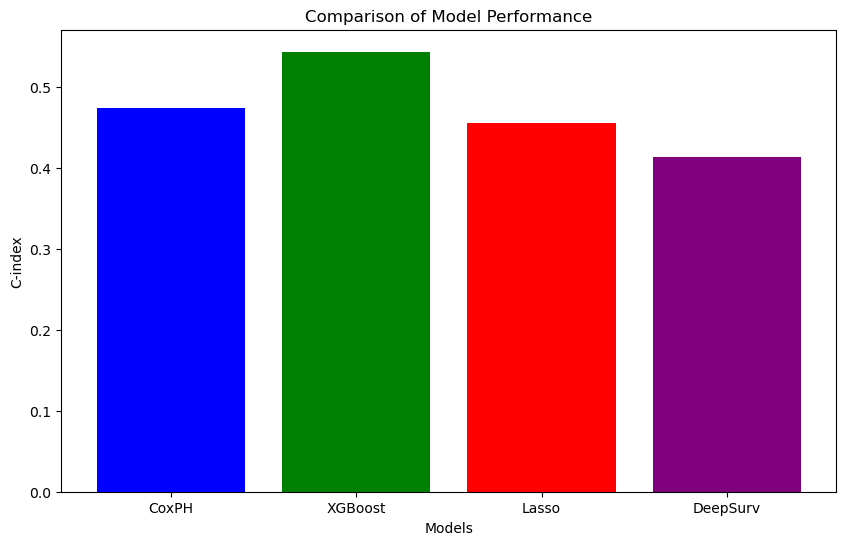

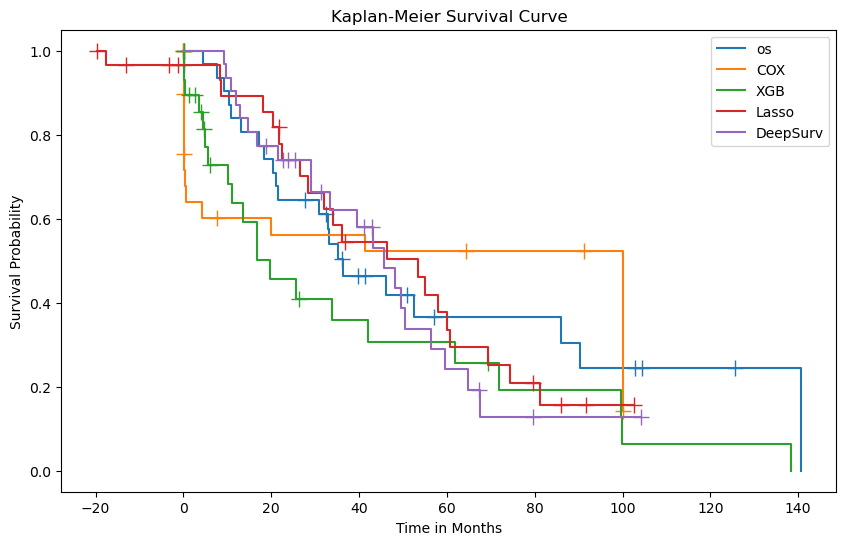

In [ ]:

# Bar plot of C-index
models = ['CoxPH', 'XGBoost', 'Lasso', 'DeepSurv']
c_indices = [cox_cindex, xgb_cindex, lasso_cindex, deepsurv_cindex]

plt.figure(figsize=(10, 6))
plt.bar(models, c_indices, color=['blue', 'green', 'red', 'purple'])
plt.xlabel('Models')
plt.ylabel('C-index')
plt.title('Comparison of Model Performance')
plt.show()

# Survival Curves (using CoxPH as example)


plt.figure(figsize=(10, 6))
model_names=['os','COX','XGB','Lasso','DeepSurv']
kmf = KaplanMeierFitter()
for i,col in enumerate(model_names):
    # if col=='COX':
    #     continue
    kmf.fit(y_com[col], event_observed=y_com['oss'])
    kmf.plot_survival_function(show_censors=True,ci_show=False,label=col)

plt.title('Kaplan-Meier Survival Curve')
plt.xlabel('Time in Months')
plt.ylabel('Survival Probability')
plt.show()


<Axes: xlabel='timeline'>

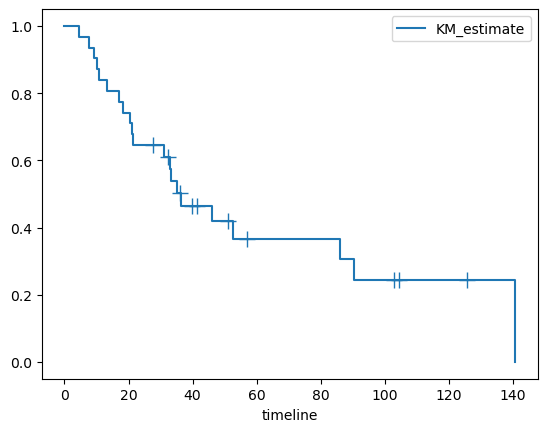

In [ ]:

kmf = KaplanMeierFitter()
kmf.fit(y_test['os'], event_observed=y_test['oss'])
kmf.plot_survival_function(show_censors=True,ci_show=False)